In [1]:
# function to reshape features into (samples, time steps, features)
def average_neigbors(W, A, noise_std, p_val):
    # return an average of the weights between the neighbors
    # the return is of shape W.shape
    (d, N_neighs) = W.shape
    for i in range(N_neighs):
        Ai = A[i, :]
        degree_i = np.sum(Ai)
#         set_trace()
        w_bar = np.sum(W[:, Ai], axis=1, keepdims=1)
        for n in range(degree_i - 1):
            w_bar += np.random.normal(loc=0, scale=noise_std)*(np.random.rand() < p_val)
        assert w_bar.shape == (d, 1)
        W[:, [i]] = w_bar/degree_i
    return W

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def gen_sequence(id_df, seq_length, seq_cols):
    # Only sequences that meet the window-length are considered, no padding is used. This means for testing
    # we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    # we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

    # function to generate labels


def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]


# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :].reshape(-1)


# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape_append1(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield np.append(data_array[start:stop, :].reshape(-1), 1)


# Gradient Solvers for FSVRG in aggregation shape (d,N
def compute_gradient_FSVRG(w, X, Y, lambda_):
    # returns a matrix of shape (d, N)
    N, d = X.shape
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y * X  # (N, d)

    return YX_neg.reshape(d, N) + 2 * lambda_ * w  # (d, N)


# Gradient Solvers
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y * X  # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T / N

    reg = 2 * lambda_ * w
    #     set_trace()

    return g + reg


# Compute hingeloss
def hinge_loss(w, X, Y):
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d, 1)
    assert Y.shape == (N, 1)
    L = 1 - Y * (X @ w)  # (N,1)
    L[L < 0] = 0
    return L


# Cost
def cost(w, X, Y):
    return np.sum(hinge_loss(w, X, Y))


# Predict
def predict(w, X):
    return np.sign(X @ w)


# Accuracy
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects / N


# Def solver
def solver(X, Y, X_test, Y_test, A, W, alpha, num_iters, lambda_, epsilon, optimizer="GD",
           mini_batch=100, mem=False, return_cost=False, verbose=True, seed=-1,
           p_val=0, R_val=0, iter_print=False, T_FSVRG=1):
    N_workers = len(X)
    dw = W.shape[0]
    assert W.shape[1] == N_workers

    noise_std = R_val ** 0.5

    if seed != -1:
        np.random.seed(seed)

    cost_ = np.zeros(num_iters + 1)
    acc_ = np.zeros(num_iters + 1)
    cost_index = 1
    if return_cost:
        cost_[0] = cost(W[:, [cost_index]], X[cost_index], Y[cost_index])  # return the first element in cost
        acc_[0] = accuracy(W[:, [cost_index]], X_test, Y_test)             # Return the first element in accuracy

    if (optimizer == "GD"):
        for i in range(num_iters):
            W = average_neigbors(W, A, noise_std, p_val)
            if iter_print:
                print("..... num_iters =", i, "......")
            for worker_i in range(N_workers):
                # set_trace()
                w = W[:, [worker_i]]
                g = compute_gradient(w, X[worker_i], Y[worker_i], lambda_)
                W[:, [worker_i]] = w - alpha * g

            if return_cost:
                cost_[i + 1] = cost(W[:, [cost_index]], X[cost_index], Y[cost_index])
                acc_[i + 1] = accuracy(W[:, [cost_index]], X_test, Y_test)

        if (verbose):
            print("GD: Number of iterations: ", num_iters, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))


    elif (optimizer == "SGD"):
        for i in range(num_iters):
            W = average_neigbors(W, A, noise_std, p_val)
            if iter_print:
                print("..... num_iters_SGD =", i, "......")
            for worker_i in range(N_workers):
                N, d = X[worker_i].shape
                i_ = int(N * np.random.rand(1))
                X_ = X[worker_i][[i_], :]
                Y_ = Y[worker_i][[i_], :]

                w = W[:, [worker_i]]
                gi = compute_gradient(w, X_, Y_, lambda_) # , size=(dw, 1)
                W[:, [worker_i]] = w - alpha * gi

            if return_cost:
                cost_[i + 1] = cost(W[:, [cost_index]], X[cost_index], Y[cost_index])
                acc_[i + 1] = accuracy(W[:, [cost_index]], X_test, Y_test)

        if (verbose):
            print("SGD: Number of iterations: ", num_iters, "/", num_iters)
            print("SGD: final norm: ", np.linalg.norm(gi))


    elif (optimizer == "FSVRG"):
        T = T_FSVRG
        # epoch length
        K = math.floor(num_iters / T)
        # number of epochs, given number of iteration
        if K == 0:
            # only run for one epoch consisting of num_iters iterations
            K = 1
            T = num_iters

        # Aggregation of all gradients from the workes
        G_vec = np.zeros(shape=(dw, N))  # (d, N)
        w_k = np.zeros(shape=(dw, N_workers))  # (d, N_workers)

        for i in range(num_iters):

            for worker_i in range(N_workers):
                N, d = X[worker_i].shape
                X_ = X[worker_i]
                Y_ = Y[worker_i]
                gi = compute_gradient_FSVRG(w, X_, Y_, lambda_) \
                     + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # (d, N) , size=(dw, N)

                G_vec = G_vec + gi  # aggregation of gradients in server

            G_vec = ((1 / N_workers) * G_vec) \
                    + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # (d, N) , size=(dw, N)
            G_ = (1 / N) * np.sum(G_vec, axis=1, keepdims=1)  # (d, 1)

            for worker_i in range(N_workers):
                w_k[:, worker_i] = w[:, 0]
                for t in range(T):
                    i_ = int(N * np.random.rand(1))
                    X_ = X[worker_i][[i_], :]  # (1, d)
                    Y_ = Y[worker_i][[i_], :]  # (1, 1)

                    g = compute_gradient(w, X_, Y_, lambda_)  # (d, 1)

                    assert g.shape == (dw, 1)
                    assert G_vec[:, [i_]].shape == (dw, 1)
                    assert G_.shape == (dw, 1)

                    w_k[:, worker_i] = w_k[:, worker_i] - alpha * (g - G_vec[:, [i_]] + G_).reshape(dw)
            w_k = w_k + (np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)) / 2000
            w = (1 / N_workers) * np.sum(w_k, axis=1, keepdims=1)

            if return_cost:
                cost_[i + 1] = cost(w, X[0], Y[0])
                acc_[i + 1] = accuracy(w, X_test, Y_test)

            if (verbose):
                print("FSVRG: Number of iterations: ", i, "/", num_iters)
                print("FSVRG: final norm: ", np.linalg.norm(g - G_vec[:, [i_]] + G_))

    if return_cost:
        return cost_, w, W, acc_


In [2]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHGSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace

#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM, Activation

import time
import math
import sys

# the "resource" library is not available on windows.
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource

    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

train_df = pd.read_csv('train_FD004.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']
########################################################################################################################
train_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
train_df.head()
########################################################################################################################
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()
########################################################################################################################
w1 = 50
w0 = 30
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, -1)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()
########################################################################################################################
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)
train_df.head()
########################################################################################################################
clipResponse = True
if clipResponse:
    rulThreshold = 150
    for i in range(len(train_df['RUL'])):
        train_df.loc[i, 'RUL'] = min(train_df.loc[i, 'RUL'], rulThreshold)
train_df.head()
########################################################################################################################
train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()
train_df.shape
########################################################################################################################
test_df = pd.read_csv('test_FD004.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()
########################################################################################################################
test_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
test_df.head()
########################################################################################################################
truth_df = pd.read_csv('RUL_FD004.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()
########################################################################################################################
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()
########################################################################################################################
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)
########################################################################################################################
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()
########################################################################################################################
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, -1)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()
test_df.shape
########################################################################################################################
column_order = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
                's14', 's15', 's17', 's20', 's21', 'RUL', 'label1', 'label2', 'cycle_norm']

test_df = test_df.reindex(columns=column_order)
########################################################################################################################


Failed on importing 'resource' package, continuing wihtout it!


In [3]:
sequence_length = 20
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's7', 's8', 's9', 's11']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 2, 3, 4, 7, 8, 9, 11
# ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 12, 13, 14, 15, 17, 20, 21
# ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))
########################################################################################################################
# pick the feature columns
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)
########################################################################################################################
# Train data
# generator train data for the sequences for each agent and save in a list
data_array_ = {}
for i in train_df['id'].unique():
    seq_gen_ = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length, sequence_cols)) for id in [i])
    data_array_[i] = np.concatenate(list(seq_gen_)).astype(np.float32)
print(len(data_array_))
########################################################################################################################
label_array_ = {}
# generate train labels for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_ = (gen_labels(train_df[train_df['id'] == id], sequence_length, ['label1']) for id in [i])
    label_array_[i] = np.concatenate(list(label_gen_)).astype(np.float32)
########################################################################################################################
label_array_rul_ = {}
# Generate train labels based on RUL for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_rul_ = (gen_labels(train_df[train_df['id'] == id], sequence_length, ['RUL']) for id in [i])
    label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)
########################################################################################################################
# Find the minimum length of dataset for each agent
min_length = label_array_rul_[1].shape[0]
for i in train_df['id'].unique():
    if min_length > label_array_rul_[i].shape[0]:
        min_length = label_array_rul_[i].shape[0]
########################################################################################################################
# set all length of lists to the minimum length of arrays
for i in train_df['id'].unique():
    label_array_rul_[i] = label_array_rul_[i][len(label_array_rul_[i]) - min_length:, :]
    label_array_[i] = label_array_[i][len(label_array_[i]) - min_length:, :]
    data_array_[i] = data_array_[i][len(data_array_[i]) - min_length:, :, :]

print(len(data_array_))
print(len(label_array_))
print(len(label_array_rul_))

print(data_array_[1].shape)
print(label_array_[1].shape)
print(label_array_rul_[1].shape)

249
249
249
249
(108, 20, 17)
(108, 1)
(108, 1)


In [4]:
########################################################################################################################
# Test Data
# generator test data for the sequences for each agent and save in a list
seq_array_test_ = {}
for i in test_df['id'].unique():
    seq_gen_test_ = (list(gen_sequence(test_df[test_df['id'] == id], sequence_length, sequence_cols)) for id in
                     [i])
    seq_array_test_[i] = np.concatenate(list(seq_gen_test_)).astype(np.float32)
########################################################################################################################
label_array_test_ = {}
# generatAe test labels for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_ = (gen_labels(test_df[test_df['id'] == id], sequence_length, ['label1']) for id in [i])
    label_array_test_[i] = np.concatenate(list(label_gen_test_)).astype(np.float32)
########################################################################################################################
label_array_test_rul_ = {}
# Generate test labels based on RUL for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_rul_ = (gen_labels(test_df[test_df['id'] == id], sequence_length, ['RUL']) for id in [i])
    label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)
########################################################################################################################
seq_array_test_tmp = {}
label_array_test_tmp = {}
label_array_test_rul_tmp = {}
for i in test_df['id'].unique():
    tmp = seq_array_test_[i].shape[0]
    if tmp >= min_length:
        seq_array_test_tmp[i] = seq_array_test_[i]
        label_array_test_tmp[i] = label_array_test_[i]
        label_array_test_rul_tmp[i] = label_array_test_rul_[i]
########################################################################################################################
# change the key of dictionary and indexing it based on increasing number from 1
seq_array_test_ = {}
label_array_test_ = {}
label_array_test_rul_ = {}
j = 1
for i in seq_array_test_tmp.keys():
    seq_array_test_[j] = seq_array_test_tmp[i]
    label_array_test_[j] = label_array_test_tmp[i]
    label_array_test_rul_[j] = label_array_test_rul_tmp[i]
    j += 1

del seq_array_test_tmp
del label_array_test_tmp
del label_array_test_rul_tmp

# set all length of test lists to the minimum length of arrays (min_length)
for i in seq_array_test_.keys():
    label_array_test_rul_[i] = label_array_test_rul_[i][len(label_array_test_rul_[i]) - min_length:, :]
    label_array_test_[i] = label_array_test_[i][len(label_array_test_[i]) - min_length:, :]
    seq_array_test_[i] = seq_array_test_[i][len(seq_array_test_[i]) - min_length:, :, :]

print(len(seq_array_test_))
print(len(label_array_test_))
print(len(label_array_test_rul_))

print(seq_array_test_[1].shape)
print(label_array_test_[1].shape)
print(label_array_test_rul_[1].shape)

X_dic = {}
Y_dic = {}
Y_rul_dic = {}
for i in data_array_.keys():
    X_dic[i - 1] = data_array_[i].reshape(min_length, -1)
    Y_dic[i - 1] = label_array_[i]
    Y_rul_dic[i - 1] = label_array_rul_[i]

X_test_dic = {}
Y_test_dic = {}
Y_test_rul_dic = {}
for i in seq_array_test_.keys():
    X_test_dic[i - 1] = seq_array_test_[i].reshape(min_length, -1)
    Y_test_dic[i - 1] = label_array_test_[i]
    Y_test_rul_dic[i - 1] = label_array_test_rul_[i]

151
151
151
(108, 20, 17)
(108, 1)
(108, 1)


In [5]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
A = np.identity(10, dtype='int8')
A[4, 0:6] = 1
A[5, 4:10] = 1
A[0:5, 4] = 1
A[5:10, 5] = 1
print(A)
A = A.astype('bool')

[[1 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 1]]


In [6]:
num_workers = 10
# Select random workers
index = [rand_num for rand_num in [random.randrange(*sorted([0, len(X_dic)])) for i in range(len(X_dic))]]
index = np.array(index)
index = index.reshape(-1, 1)
index = index[0:math.floor(len(data_array_)/num_workers)*num_workers, :]
index = index.reshape(-1, num_workers)
X = [np.concatenate(([X_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
Y = [np.concatenate(([Y_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
Y_rul = [np.concatenate(([Y_rul_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
#X = [X_dic[i] for i in index]
#Y = [Y_dic[i] for i in index]
#Y_rul = [Y_rul_dic[i] for i in index]


X_test = np.array([[X_test_dic[i]] for i in range(len(X_test_dic))]).reshape(-1, X_test_dic[0].shape[1])
Y_test = np.array([[Y_test_dic[i]] for i in range(len(X_test_dic))]).reshape(-1, Y_test_dic[0].shape[1])
print(X_test.shape)
print(Y_test.shape)

(16308, 340)
(16308, 1)


In [7]:
d = X[0].shape[1]
w = np.random.rand(d, 10)
alpha = 0.01
num_iters = 3000
lambda_ = 0.1
epsilon = 0
p_val = 0.0
R_val = 0.0
########################################################################################################################

In [8]:
# Run GD
time1 = time.time()
cost_GD, w_out_GD, W_GD, acc_GD = solver(X, Y, X_test, Y_test, A, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime GD num_iters=", time2 - time1)
print("final cost with GD", cost_GD[-1])
W_Cloud_GD = W_GD[:, 4].reshape(d, 1) + W_GD[:, 5].reshape(d, 1) / 2
acc_final_GD= accuracy(W_Cloud_GD, X_test, Y_test)
print("final acc on Cloud FedSVM_GD:", acc_final_GD)
print("-------------------------------------")

..... num_iters = 0 ......
..... num_iters = 1 ......
..... num_iters = 2 ......
..... num_iters = 3 ......
..... num_iters = 4 ......
..... num_iters = 5 ......
..... num_iters = 6 ......
..... num_iters = 7 ......
..... num_iters = 8 ......
..... num_iters = 9 ......
..... num_iters = 10 ......
..... num_iters = 11 ......
..... num_iters = 12 ......
..... num_iters = 13 ......
..... num_iters = 14 ......
..... num_iters = 15 ......
..... num_iters = 16 ......
..... num_iters = 17 ......
..... num_iters = 18 ......
..... num_iters = 19 ......
..... num_iters = 20 ......
..... num_iters = 21 ......
..... num_iters = 22 ......
..... num_iters = 23 ......
..... num_iters = 24 ......
..... num_iters = 25 ......
..... num_iters = 26 ......
..... num_iters = 27 ......
..... num_iters = 28 ......
..... num_iters = 29 ......
..... num_iters = 30 ......
..... num_iters = 31 ......
..... num_iters = 32 ......
..... num_iters = 33 ......
..... num_iters = 34 ......
..... num_iters = 35 ......
..

..... num_iters = 287 ......
..... num_iters = 288 ......
..... num_iters = 289 ......
..... num_iters = 290 ......
..... num_iters = 291 ......
..... num_iters = 292 ......
..... num_iters = 293 ......
..... num_iters = 294 ......
..... num_iters = 295 ......
..... num_iters = 296 ......
..... num_iters = 297 ......
..... num_iters = 298 ......
..... num_iters = 299 ......
..... num_iters = 300 ......
..... num_iters = 301 ......
..... num_iters = 302 ......
..... num_iters = 303 ......
..... num_iters = 304 ......
..... num_iters = 305 ......
..... num_iters = 306 ......
..... num_iters = 307 ......
..... num_iters = 308 ......
..... num_iters = 309 ......
..... num_iters = 310 ......
..... num_iters = 311 ......
..... num_iters = 312 ......
..... num_iters = 313 ......
..... num_iters = 314 ......
..... num_iters = 315 ......
..... num_iters = 316 ......
..... num_iters = 317 ......
..... num_iters = 318 ......
..... num_iters = 319 ......
..... num_iters = 320 ......
..... num_iter

..... num_iters = 570 ......
..... num_iters = 571 ......
..... num_iters = 572 ......
..... num_iters = 573 ......
..... num_iters = 574 ......
..... num_iters = 575 ......
..... num_iters = 576 ......
..... num_iters = 577 ......
..... num_iters = 578 ......
..... num_iters = 579 ......
..... num_iters = 580 ......
..... num_iters = 581 ......
..... num_iters = 582 ......
..... num_iters = 583 ......
..... num_iters = 584 ......
..... num_iters = 585 ......
..... num_iters = 586 ......
..... num_iters = 587 ......
..... num_iters = 588 ......
..... num_iters = 589 ......
..... num_iters = 590 ......
..... num_iters = 591 ......
..... num_iters = 592 ......
..... num_iters = 593 ......
..... num_iters = 594 ......
..... num_iters = 595 ......
..... num_iters = 596 ......
..... num_iters = 597 ......
..... num_iters = 598 ......
..... num_iters = 599 ......
..... num_iters = 600 ......
..... num_iters = 601 ......
..... num_iters = 602 ......
..... num_iters = 603 ......
..... num_iter

..... num_iters = 853 ......
..... num_iters = 854 ......
..... num_iters = 855 ......
..... num_iters = 856 ......
..... num_iters = 857 ......
..... num_iters = 858 ......
..... num_iters = 859 ......
..... num_iters = 860 ......
..... num_iters = 861 ......
..... num_iters = 862 ......
..... num_iters = 863 ......
..... num_iters = 864 ......
..... num_iters = 865 ......
..... num_iters = 866 ......
..... num_iters = 867 ......
..... num_iters = 868 ......
..... num_iters = 869 ......
..... num_iters = 870 ......
..... num_iters = 871 ......
..... num_iters = 872 ......
..... num_iters = 873 ......
..... num_iters = 874 ......
..... num_iters = 875 ......
..... num_iters = 876 ......
..... num_iters = 877 ......
..... num_iters = 878 ......
..... num_iters = 879 ......
..... num_iters = 880 ......
..... num_iters = 881 ......
..... num_iters = 882 ......
..... num_iters = 883 ......
..... num_iters = 884 ......
..... num_iters = 885 ......
..... num_iters = 886 ......
..... num_iter

..... num_iters = 1132 ......
..... num_iters = 1133 ......
..... num_iters = 1134 ......
..... num_iters = 1135 ......
..... num_iters = 1136 ......
..... num_iters = 1137 ......
..... num_iters = 1138 ......
..... num_iters = 1139 ......
..... num_iters = 1140 ......
..... num_iters = 1141 ......
..... num_iters = 1142 ......
..... num_iters = 1143 ......
..... num_iters = 1144 ......
..... num_iters = 1145 ......
..... num_iters = 1146 ......
..... num_iters = 1147 ......
..... num_iters = 1148 ......
..... num_iters = 1149 ......
..... num_iters = 1150 ......
..... num_iters = 1151 ......
..... num_iters = 1152 ......
..... num_iters = 1153 ......
..... num_iters = 1154 ......
..... num_iters = 1155 ......
..... num_iters = 1156 ......
..... num_iters = 1157 ......
..... num_iters = 1158 ......
..... num_iters = 1159 ......
..... num_iters = 1160 ......
..... num_iters = 1161 ......
..... num_iters = 1162 ......
..... num_iters = 1163 ......
..... num_iters = 1164 ......
..... num_

..... num_iters = 1406 ......
..... num_iters = 1407 ......
..... num_iters = 1408 ......
..... num_iters = 1409 ......
..... num_iters = 1410 ......
..... num_iters = 1411 ......
..... num_iters = 1412 ......
..... num_iters = 1413 ......
..... num_iters = 1414 ......
..... num_iters = 1415 ......
..... num_iters = 1416 ......
..... num_iters = 1417 ......
..... num_iters = 1418 ......
..... num_iters = 1419 ......
..... num_iters = 1420 ......
..... num_iters = 1421 ......
..... num_iters = 1422 ......
..... num_iters = 1423 ......
..... num_iters = 1424 ......
..... num_iters = 1425 ......
..... num_iters = 1426 ......
..... num_iters = 1427 ......
..... num_iters = 1428 ......
..... num_iters = 1429 ......
..... num_iters = 1430 ......
..... num_iters = 1431 ......
..... num_iters = 1432 ......
..... num_iters = 1433 ......
..... num_iters = 1434 ......
..... num_iters = 1435 ......
..... num_iters = 1436 ......
..... num_iters = 1437 ......
..... num_iters = 1438 ......
..... num_

..... num_iters = 1680 ......
..... num_iters = 1681 ......
..... num_iters = 1682 ......
..... num_iters = 1683 ......
..... num_iters = 1684 ......
..... num_iters = 1685 ......
..... num_iters = 1686 ......
..... num_iters = 1687 ......
..... num_iters = 1688 ......
..... num_iters = 1689 ......
..... num_iters = 1690 ......
..... num_iters = 1691 ......
..... num_iters = 1692 ......
..... num_iters = 1693 ......
..... num_iters = 1694 ......
..... num_iters = 1695 ......
..... num_iters = 1696 ......
..... num_iters = 1697 ......
..... num_iters = 1698 ......
..... num_iters = 1699 ......
..... num_iters = 1700 ......
..... num_iters = 1701 ......
..... num_iters = 1702 ......
..... num_iters = 1703 ......
..... num_iters = 1704 ......
..... num_iters = 1705 ......
..... num_iters = 1706 ......
..... num_iters = 1707 ......
..... num_iters = 1708 ......
..... num_iters = 1709 ......
..... num_iters = 1710 ......
..... num_iters = 1711 ......
..... num_iters = 1712 ......
..... num_

..... num_iters = 1955 ......
..... num_iters = 1956 ......
..... num_iters = 1957 ......
..... num_iters = 1958 ......
..... num_iters = 1959 ......
..... num_iters = 1960 ......
..... num_iters = 1961 ......
..... num_iters = 1962 ......
..... num_iters = 1963 ......
..... num_iters = 1964 ......
..... num_iters = 1965 ......
..... num_iters = 1966 ......
..... num_iters = 1967 ......
..... num_iters = 1968 ......
..... num_iters = 1969 ......
..... num_iters = 1970 ......
..... num_iters = 1971 ......
..... num_iters = 1972 ......
..... num_iters = 1973 ......
..... num_iters = 1974 ......
..... num_iters = 1975 ......
..... num_iters = 1976 ......
..... num_iters = 1977 ......
..... num_iters = 1978 ......
..... num_iters = 1979 ......
..... num_iters = 1980 ......
..... num_iters = 1981 ......
..... num_iters = 1982 ......
..... num_iters = 1983 ......
..... num_iters = 1984 ......
..... num_iters = 1985 ......
..... num_iters = 1986 ......
..... num_iters = 1987 ......
..... num_

..... num_iters = 2230 ......
..... num_iters = 2231 ......
..... num_iters = 2232 ......
..... num_iters = 2233 ......
..... num_iters = 2234 ......
..... num_iters = 2235 ......
..... num_iters = 2236 ......
..... num_iters = 2237 ......
..... num_iters = 2238 ......
..... num_iters = 2239 ......
..... num_iters = 2240 ......
..... num_iters = 2241 ......
..... num_iters = 2242 ......
..... num_iters = 2243 ......
..... num_iters = 2244 ......
..... num_iters = 2245 ......
..... num_iters = 2246 ......
..... num_iters = 2247 ......
..... num_iters = 2248 ......
..... num_iters = 2249 ......
..... num_iters = 2250 ......
..... num_iters = 2251 ......
..... num_iters = 2252 ......
..... num_iters = 2253 ......
..... num_iters = 2254 ......
..... num_iters = 2255 ......
..... num_iters = 2256 ......
..... num_iters = 2257 ......
..... num_iters = 2258 ......
..... num_iters = 2259 ......
..... num_iters = 2260 ......
..... num_iters = 2261 ......
..... num_iters = 2262 ......
..... num_

..... num_iters = 2504 ......
..... num_iters = 2505 ......
..... num_iters = 2506 ......
..... num_iters = 2507 ......
..... num_iters = 2508 ......
..... num_iters = 2509 ......
..... num_iters = 2510 ......
..... num_iters = 2511 ......
..... num_iters = 2512 ......
..... num_iters = 2513 ......
..... num_iters = 2514 ......
..... num_iters = 2515 ......
..... num_iters = 2516 ......
..... num_iters = 2517 ......
..... num_iters = 2518 ......
..... num_iters = 2519 ......
..... num_iters = 2520 ......
..... num_iters = 2521 ......
..... num_iters = 2522 ......
..... num_iters = 2523 ......
..... num_iters = 2524 ......
..... num_iters = 2525 ......
..... num_iters = 2526 ......
..... num_iters = 2527 ......
..... num_iters = 2528 ......
..... num_iters = 2529 ......
..... num_iters = 2530 ......
..... num_iters = 2531 ......
..... num_iters = 2532 ......
..... num_iters = 2533 ......
..... num_iters = 2534 ......
..... num_iters = 2535 ......
..... num_iters = 2536 ......
..... num_

..... num_iters = 2777 ......
..... num_iters = 2778 ......
..... num_iters = 2779 ......
..... num_iters = 2780 ......
..... num_iters = 2781 ......
..... num_iters = 2782 ......
..... num_iters = 2783 ......
..... num_iters = 2784 ......
..... num_iters = 2785 ......
..... num_iters = 2786 ......
..... num_iters = 2787 ......
..... num_iters = 2788 ......
..... num_iters = 2789 ......
..... num_iters = 2790 ......
..... num_iters = 2791 ......
..... num_iters = 2792 ......
..... num_iters = 2793 ......
..... num_iters = 2794 ......
..... num_iters = 2795 ......
..... num_iters = 2796 ......
..... num_iters = 2797 ......
..... num_iters = 2798 ......
..... num_iters = 2799 ......
..... num_iters = 2800 ......
..... num_iters = 2801 ......
..... num_iters = 2802 ......
..... num_iters = 2803 ......
..... num_iters = 2804 ......
..... num_iters = 2805 ......
..... num_iters = 2806 ......
..... num_iters = 2807 ......
..... num_iters = 2808 ......
..... num_iters = 2809 ......
..... num_

In [9]:
########################################################################################################################
d = X[0].shape[1]
w = np.random.rand(d, 10)
alpha = 0.01
num_iters = 3000
lambda_ = 0.1
epsilon = 0
p_val = 0.0
R_val = 0.0
# Run SGD
time1 = time.time()
cost_SGD, w_out_SGD, W_SGD, acc_SGD = solver(X, Y, X_test, Y_test, A, w, alpha, num_iters, lambda_, epsilon, optimizer="SGD",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime SGD num_iters=", time2 - time1)
print("final cost with SGD", cost_SGD[-1])
W_Cloud_SGD = W_SGD[:, 4].reshape(d, 1) + W_SGD[:, 5].reshape(d, 1) / 2
acc_final_SGD = accuracy(W_Cloud_SGD, X_test, Y_test)
print("final acc on Cloud FedSVM_SGD:", acc_final_SGD)
print("-------------------------------------")

..... num_iters_SGD = 0 ......
..... num_iters_SGD = 1 ......
..... num_iters_SGD = 2 ......
..... num_iters_SGD = 3 ......
..... num_iters_SGD = 4 ......
..... num_iters_SGD = 5 ......
..... num_iters_SGD = 6 ......
..... num_iters_SGD = 7 ......
..... num_iters_SGD = 8 ......
..... num_iters_SGD = 9 ......
..... num_iters_SGD = 10 ......
..... num_iters_SGD = 11 ......
..... num_iters_SGD = 12 ......
..... num_iters_SGD = 13 ......
..... num_iters_SGD = 14 ......
..... num_iters_SGD = 15 ......
..... num_iters_SGD = 16 ......
..... num_iters_SGD = 17 ......
..... num_iters_SGD = 18 ......
..... num_iters_SGD = 19 ......
..... num_iters_SGD = 20 ......
..... num_iters_SGD = 21 ......
..... num_iters_SGD = 22 ......
..... num_iters_SGD = 23 ......
..... num_iters_SGD = 24 ......
..... num_iters_SGD = 25 ......
..... num_iters_SGD = 26 ......
..... num_iters_SGD = 27 ......
..... num_iters_SGD = 28 ......
..... num_iters_SGD = 29 ......
..... num_iters_SGD = 30 ......
..... num_iters_SG

..... num_iters_SGD = 253 ......
..... num_iters_SGD = 254 ......
..... num_iters_SGD = 255 ......
..... num_iters_SGD = 256 ......
..... num_iters_SGD = 257 ......
..... num_iters_SGD = 258 ......
..... num_iters_SGD = 259 ......
..... num_iters_SGD = 260 ......
..... num_iters_SGD = 261 ......
..... num_iters_SGD = 262 ......
..... num_iters_SGD = 263 ......
..... num_iters_SGD = 264 ......
..... num_iters_SGD = 265 ......
..... num_iters_SGD = 266 ......
..... num_iters_SGD = 267 ......
..... num_iters_SGD = 268 ......
..... num_iters_SGD = 269 ......
..... num_iters_SGD = 270 ......
..... num_iters_SGD = 271 ......
..... num_iters_SGD = 272 ......
..... num_iters_SGD = 273 ......
..... num_iters_SGD = 274 ......
..... num_iters_SGD = 275 ......
..... num_iters_SGD = 276 ......
..... num_iters_SGD = 277 ......
..... num_iters_SGD = 278 ......
..... num_iters_SGD = 279 ......
..... num_iters_SGD = 280 ......
..... num_iters_SGD = 281 ......
..... num_iters_SGD = 282 ......
..... num_

..... num_iters_SGD = 508 ......
..... num_iters_SGD = 509 ......
..... num_iters_SGD = 510 ......
..... num_iters_SGD = 511 ......
..... num_iters_SGD = 512 ......
..... num_iters_SGD = 513 ......
..... num_iters_SGD = 514 ......
..... num_iters_SGD = 515 ......
..... num_iters_SGD = 516 ......
..... num_iters_SGD = 517 ......
..... num_iters_SGD = 518 ......
..... num_iters_SGD = 519 ......
..... num_iters_SGD = 520 ......
..... num_iters_SGD = 521 ......
..... num_iters_SGD = 522 ......
..... num_iters_SGD = 523 ......
..... num_iters_SGD = 524 ......
..... num_iters_SGD = 525 ......
..... num_iters_SGD = 526 ......
..... num_iters_SGD = 527 ......
..... num_iters_SGD = 528 ......
..... num_iters_SGD = 529 ......
..... num_iters_SGD = 530 ......
..... num_iters_SGD = 531 ......
..... num_iters_SGD = 532 ......
..... num_iters_SGD = 533 ......
..... num_iters_SGD = 534 ......
..... num_iters_SGD = 535 ......
..... num_iters_SGD = 536 ......
..... num_iters_SGD = 537 ......
..... num_

..... num_iters_SGD = 759 ......
..... num_iters_SGD = 760 ......
..... num_iters_SGD = 761 ......
..... num_iters_SGD = 762 ......
..... num_iters_SGD = 763 ......
..... num_iters_SGD = 764 ......
..... num_iters_SGD = 765 ......
..... num_iters_SGD = 766 ......
..... num_iters_SGD = 767 ......
..... num_iters_SGD = 768 ......
..... num_iters_SGD = 769 ......
..... num_iters_SGD = 770 ......
..... num_iters_SGD = 771 ......
..... num_iters_SGD = 772 ......
..... num_iters_SGD = 773 ......
..... num_iters_SGD = 774 ......
..... num_iters_SGD = 775 ......
..... num_iters_SGD = 776 ......
..... num_iters_SGD = 777 ......
..... num_iters_SGD = 778 ......
..... num_iters_SGD = 779 ......
..... num_iters_SGD = 780 ......
..... num_iters_SGD = 781 ......
..... num_iters_SGD = 782 ......
..... num_iters_SGD = 783 ......
..... num_iters_SGD = 784 ......
..... num_iters_SGD = 785 ......
..... num_iters_SGD = 786 ......
..... num_iters_SGD = 787 ......
..... num_iters_SGD = 788 ......
..... num_

..... num_iters_SGD = 1011 ......
..... num_iters_SGD = 1012 ......
..... num_iters_SGD = 1013 ......
..... num_iters_SGD = 1014 ......
..... num_iters_SGD = 1015 ......
..... num_iters_SGD = 1016 ......
..... num_iters_SGD = 1017 ......
..... num_iters_SGD = 1018 ......
..... num_iters_SGD = 1019 ......
..... num_iters_SGD = 1020 ......
..... num_iters_SGD = 1021 ......
..... num_iters_SGD = 1022 ......
..... num_iters_SGD = 1023 ......
..... num_iters_SGD = 1024 ......
..... num_iters_SGD = 1025 ......
..... num_iters_SGD = 1026 ......
..... num_iters_SGD = 1027 ......
..... num_iters_SGD = 1028 ......
..... num_iters_SGD = 1029 ......
..... num_iters_SGD = 1030 ......
..... num_iters_SGD = 1031 ......
..... num_iters_SGD = 1032 ......
..... num_iters_SGD = 1033 ......
..... num_iters_SGD = 1034 ......
..... num_iters_SGD = 1035 ......
..... num_iters_SGD = 1036 ......
..... num_iters_SGD = 1037 ......
..... num_iters_SGD = 1038 ......
..... num_iters_SGD = 1039 ......
..... num_iter

..... num_iters_SGD = 1254 ......
..... num_iters_SGD = 1255 ......
..... num_iters_SGD = 1256 ......
..... num_iters_SGD = 1257 ......
..... num_iters_SGD = 1258 ......
..... num_iters_SGD = 1259 ......
..... num_iters_SGD = 1260 ......
..... num_iters_SGD = 1261 ......
..... num_iters_SGD = 1262 ......
..... num_iters_SGD = 1263 ......
..... num_iters_SGD = 1264 ......
..... num_iters_SGD = 1265 ......
..... num_iters_SGD = 1266 ......
..... num_iters_SGD = 1267 ......
..... num_iters_SGD = 1268 ......
..... num_iters_SGD = 1269 ......
..... num_iters_SGD = 1270 ......
..... num_iters_SGD = 1271 ......
..... num_iters_SGD = 1272 ......
..... num_iters_SGD = 1273 ......
..... num_iters_SGD = 1274 ......
..... num_iters_SGD = 1275 ......
..... num_iters_SGD = 1276 ......
..... num_iters_SGD = 1277 ......
..... num_iters_SGD = 1278 ......
..... num_iters_SGD = 1279 ......
..... num_iters_SGD = 1280 ......
..... num_iters_SGD = 1281 ......
..... num_iters_SGD = 1282 ......
..... num_iter

..... num_iters_SGD = 1496 ......
..... num_iters_SGD = 1497 ......
..... num_iters_SGD = 1498 ......
..... num_iters_SGD = 1499 ......
..... num_iters_SGD = 1500 ......
..... num_iters_SGD = 1501 ......
..... num_iters_SGD = 1502 ......
..... num_iters_SGD = 1503 ......
..... num_iters_SGD = 1504 ......
..... num_iters_SGD = 1505 ......
..... num_iters_SGD = 1506 ......
..... num_iters_SGD = 1507 ......
..... num_iters_SGD = 1508 ......
..... num_iters_SGD = 1509 ......
..... num_iters_SGD = 1510 ......
..... num_iters_SGD = 1511 ......
..... num_iters_SGD = 1512 ......
..... num_iters_SGD = 1513 ......
..... num_iters_SGD = 1514 ......
..... num_iters_SGD = 1515 ......
..... num_iters_SGD = 1516 ......
..... num_iters_SGD = 1517 ......
..... num_iters_SGD = 1518 ......
..... num_iters_SGD = 1519 ......
..... num_iters_SGD = 1520 ......
..... num_iters_SGD = 1521 ......
..... num_iters_SGD = 1522 ......
..... num_iters_SGD = 1523 ......
..... num_iters_SGD = 1524 ......
..... num_iter

..... num_iters_SGD = 1740 ......
..... num_iters_SGD = 1741 ......
..... num_iters_SGD = 1742 ......
..... num_iters_SGD = 1743 ......
..... num_iters_SGD = 1744 ......
..... num_iters_SGD = 1745 ......
..... num_iters_SGD = 1746 ......
..... num_iters_SGD = 1747 ......
..... num_iters_SGD = 1748 ......
..... num_iters_SGD = 1749 ......
..... num_iters_SGD = 1750 ......
..... num_iters_SGD = 1751 ......
..... num_iters_SGD = 1752 ......
..... num_iters_SGD = 1753 ......
..... num_iters_SGD = 1754 ......
..... num_iters_SGD = 1755 ......
..... num_iters_SGD = 1756 ......
..... num_iters_SGD = 1757 ......
..... num_iters_SGD = 1758 ......
..... num_iters_SGD = 1759 ......
..... num_iters_SGD = 1760 ......
..... num_iters_SGD = 1761 ......
..... num_iters_SGD = 1762 ......
..... num_iters_SGD = 1763 ......
..... num_iters_SGD = 1764 ......
..... num_iters_SGD = 1765 ......
..... num_iters_SGD = 1766 ......
..... num_iters_SGD = 1767 ......
..... num_iters_SGD = 1768 ......
..... num_iter

..... num_iters_SGD = 1983 ......
..... num_iters_SGD = 1984 ......
..... num_iters_SGD = 1985 ......
..... num_iters_SGD = 1986 ......
..... num_iters_SGD = 1987 ......
..... num_iters_SGD = 1988 ......
..... num_iters_SGD = 1989 ......
..... num_iters_SGD = 1990 ......
..... num_iters_SGD = 1991 ......
..... num_iters_SGD = 1992 ......
..... num_iters_SGD = 1993 ......
..... num_iters_SGD = 1994 ......
..... num_iters_SGD = 1995 ......
..... num_iters_SGD = 1996 ......
..... num_iters_SGD = 1997 ......
..... num_iters_SGD = 1998 ......
..... num_iters_SGD = 1999 ......
..... num_iters_SGD = 2000 ......
..... num_iters_SGD = 2001 ......
..... num_iters_SGD = 2002 ......
..... num_iters_SGD = 2003 ......
..... num_iters_SGD = 2004 ......
..... num_iters_SGD = 2005 ......
..... num_iters_SGD = 2006 ......
..... num_iters_SGD = 2007 ......
..... num_iters_SGD = 2008 ......
..... num_iters_SGD = 2009 ......
..... num_iters_SGD = 2010 ......
..... num_iters_SGD = 2011 ......
..... num_iter

..... num_iters_SGD = 2228 ......
..... num_iters_SGD = 2229 ......
..... num_iters_SGD = 2230 ......
..... num_iters_SGD = 2231 ......
..... num_iters_SGD = 2232 ......
..... num_iters_SGD = 2233 ......
..... num_iters_SGD = 2234 ......
..... num_iters_SGD = 2235 ......
..... num_iters_SGD = 2236 ......
..... num_iters_SGD = 2237 ......
..... num_iters_SGD = 2238 ......
..... num_iters_SGD = 2239 ......
..... num_iters_SGD = 2240 ......
..... num_iters_SGD = 2241 ......
..... num_iters_SGD = 2242 ......
..... num_iters_SGD = 2243 ......
..... num_iters_SGD = 2244 ......
..... num_iters_SGD = 2245 ......
..... num_iters_SGD = 2246 ......
..... num_iters_SGD = 2247 ......
..... num_iters_SGD = 2248 ......
..... num_iters_SGD = 2249 ......
..... num_iters_SGD = 2250 ......
..... num_iters_SGD = 2251 ......
..... num_iters_SGD = 2252 ......
..... num_iters_SGD = 2253 ......
..... num_iters_SGD = 2254 ......
..... num_iters_SGD = 2255 ......
..... num_iters_SGD = 2256 ......
..... num_iter

..... num_iters_SGD = 2474 ......
..... num_iters_SGD = 2475 ......
..... num_iters_SGD = 2476 ......
..... num_iters_SGD = 2477 ......
..... num_iters_SGD = 2478 ......
..... num_iters_SGD = 2479 ......
..... num_iters_SGD = 2480 ......
..... num_iters_SGD = 2481 ......
..... num_iters_SGD = 2482 ......
..... num_iters_SGD = 2483 ......
..... num_iters_SGD = 2484 ......
..... num_iters_SGD = 2485 ......
..... num_iters_SGD = 2486 ......
..... num_iters_SGD = 2487 ......
..... num_iters_SGD = 2488 ......
..... num_iters_SGD = 2489 ......
..... num_iters_SGD = 2490 ......
..... num_iters_SGD = 2491 ......
..... num_iters_SGD = 2492 ......
..... num_iters_SGD = 2493 ......
..... num_iters_SGD = 2494 ......
..... num_iters_SGD = 2495 ......
..... num_iters_SGD = 2496 ......
..... num_iters_SGD = 2497 ......
..... num_iters_SGD = 2498 ......
..... num_iters_SGD = 2499 ......
..... num_iters_SGD = 2500 ......
..... num_iters_SGD = 2501 ......
..... num_iters_SGD = 2502 ......
..... num_iter

..... num_iters_SGD = 2718 ......
..... num_iters_SGD = 2719 ......
..... num_iters_SGD = 2720 ......
..... num_iters_SGD = 2721 ......
..... num_iters_SGD = 2722 ......
..... num_iters_SGD = 2723 ......
..... num_iters_SGD = 2724 ......
..... num_iters_SGD = 2725 ......
..... num_iters_SGD = 2726 ......
..... num_iters_SGD = 2727 ......
..... num_iters_SGD = 2728 ......
..... num_iters_SGD = 2729 ......
..... num_iters_SGD = 2730 ......
..... num_iters_SGD = 2731 ......
..... num_iters_SGD = 2732 ......
..... num_iters_SGD = 2733 ......
..... num_iters_SGD = 2734 ......
..... num_iters_SGD = 2735 ......
..... num_iters_SGD = 2736 ......
..... num_iters_SGD = 2737 ......
..... num_iters_SGD = 2738 ......
..... num_iters_SGD = 2739 ......
..... num_iters_SGD = 2740 ......
..... num_iters_SGD = 2741 ......
..... num_iters_SGD = 2742 ......
..... num_iters_SGD = 2743 ......
..... num_iters_SGD = 2744 ......
..... num_iters_SGD = 2745 ......
..... num_iters_SGD = 2746 ......
..... num_iter

..... num_iters_SGD = 2959 ......
..... num_iters_SGD = 2960 ......
..... num_iters_SGD = 2961 ......
..... num_iters_SGD = 2962 ......
..... num_iters_SGD = 2963 ......
..... num_iters_SGD = 2964 ......
..... num_iters_SGD = 2965 ......
..... num_iters_SGD = 2966 ......
..... num_iters_SGD = 2967 ......
..... num_iters_SGD = 2968 ......
..... num_iters_SGD = 2969 ......
..... num_iters_SGD = 2970 ......
..... num_iters_SGD = 2971 ......
..... num_iters_SGD = 2972 ......
..... num_iters_SGD = 2973 ......
..... num_iters_SGD = 2974 ......
..... num_iters_SGD = 2975 ......
..... num_iters_SGD = 2976 ......
..... num_iters_SGD = 2977 ......
..... num_iters_SGD = 2978 ......
..... num_iters_SGD = 2979 ......
..... num_iters_SGD = 2980 ......
..... num_iters_SGD = 2981 ......
..... num_iters_SGD = 2982 ......
..... num_iters_SGD = 2983 ......
..... num_iters_SGD = 2984 ......
..... num_iters_SGD = 2985 ......
..... num_iters_SGD = 2986 ......
..... num_iters_SGD = 2987 ......
..... num_iter

C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


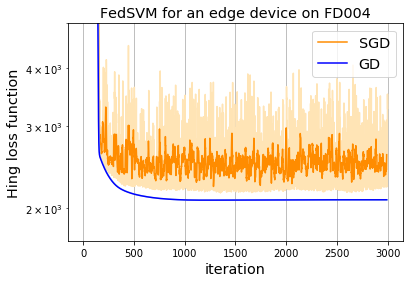

In [11]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
# plot costs
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
plt.plot(cost_SGD, 'moccasin')
plt.plot(running_mean(cost_SGD, 10), 'darkorange', label="SGD")
plt.plot(cost_GD, 'lightblue')
plt.plot(running_mean(cost_GD, 10), 'b', label="GD")
plt.legend(loc="best", fontsize="x-large")
plt.yscale('log')
plt.title("FedSVM for an edge device on FD004", fontsize="x-large")
plt.ylabel("Hing loss function", fontsize="x-large")
plt.xlabel("iteration", fontsize="x-large")
plt.grid()
plt.ylim(0, 5000)
dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/fog&cloud/FD004/Results/"

plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
plt.savefig("Hing loss function in FedSVM asynchronous FD004.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.savefig("Hing loss function in FedSVM asynchronous FD004.png", format='png', dpi=1200, bbox_inches='tight')


C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\alibei\.conda\envs\myjupyter\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

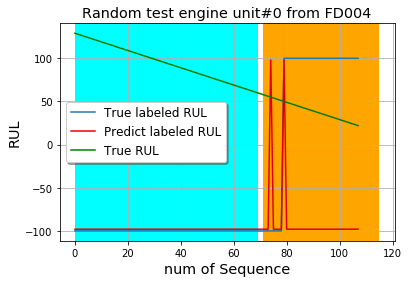

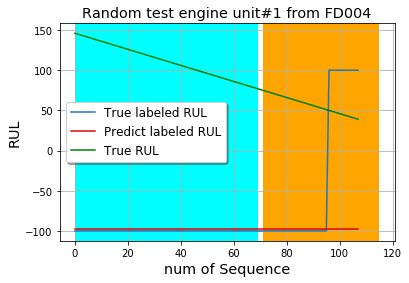

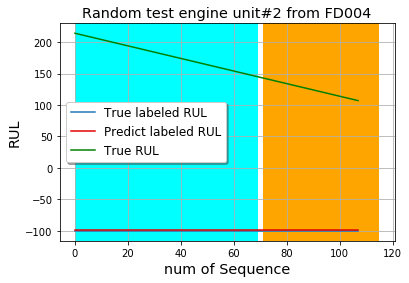

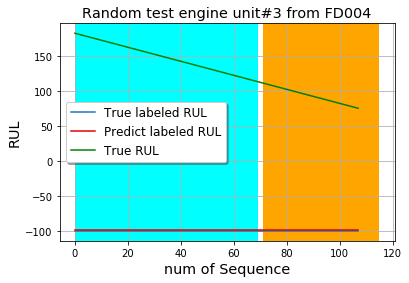

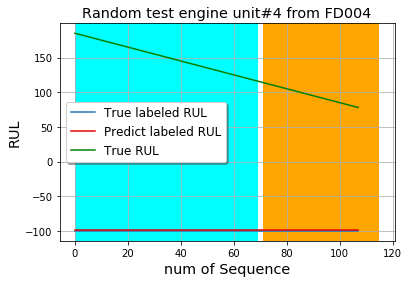

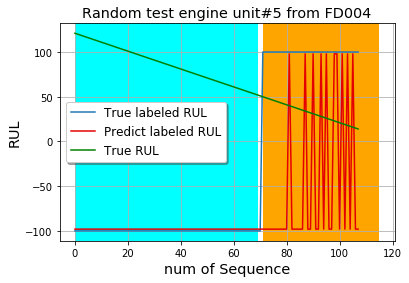

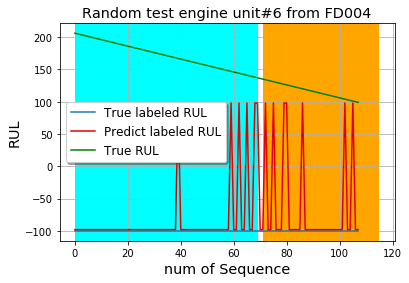

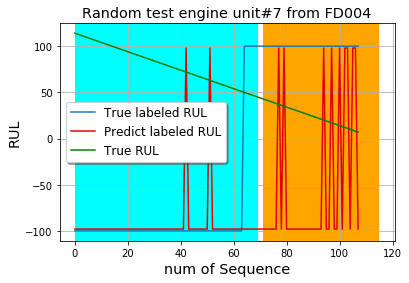

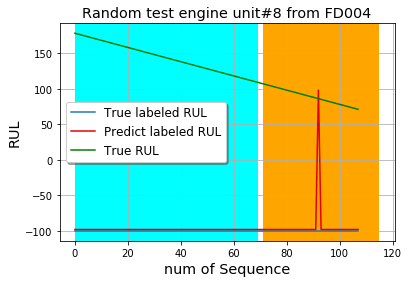

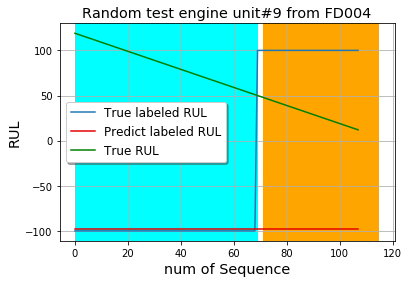

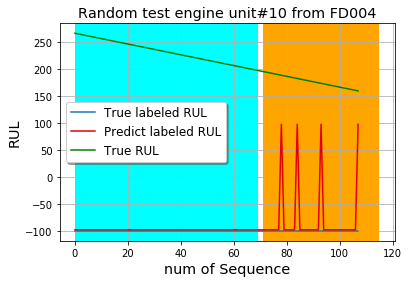

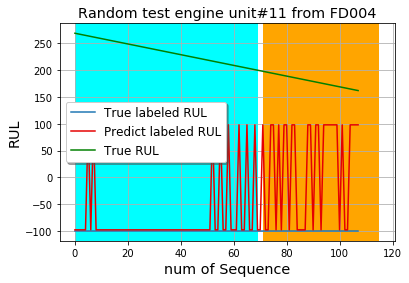

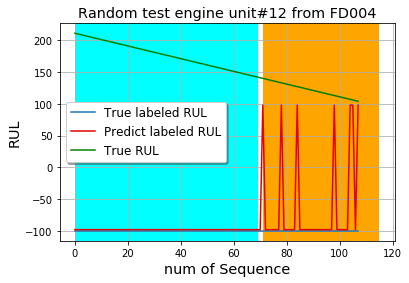

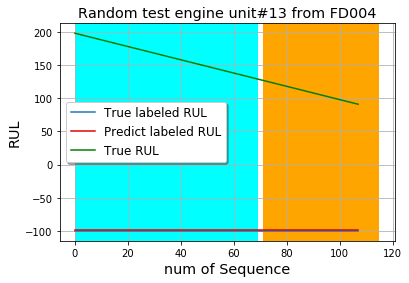

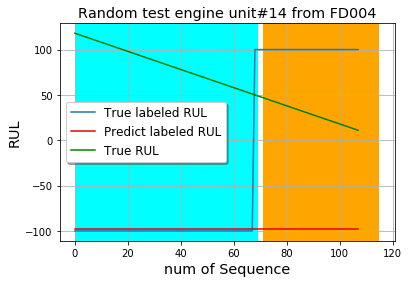

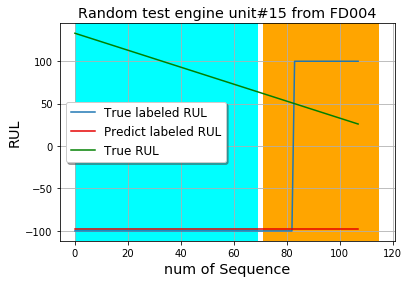

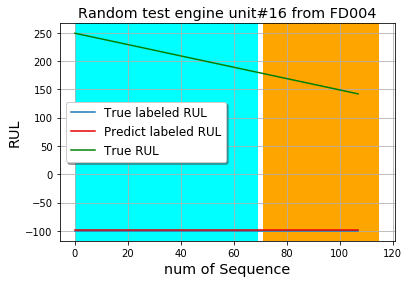

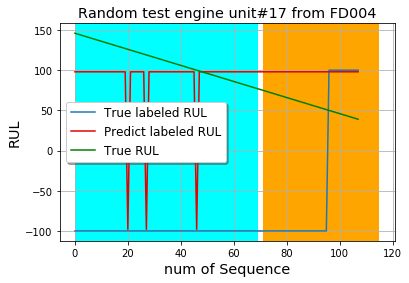

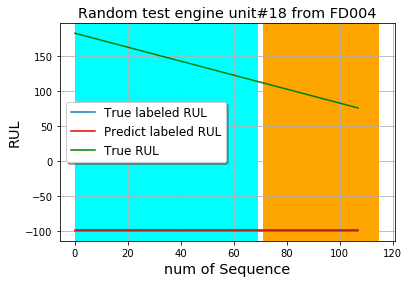

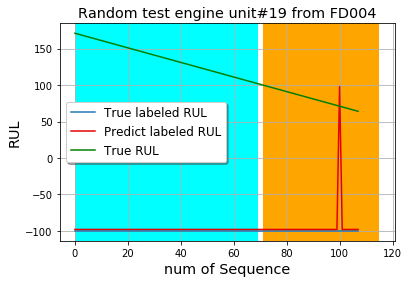

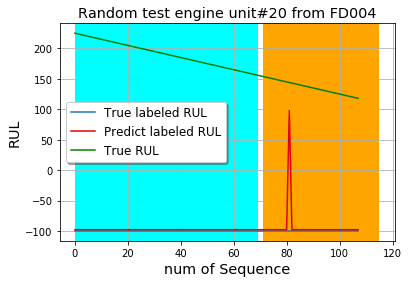

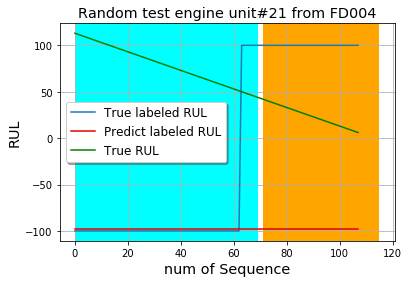

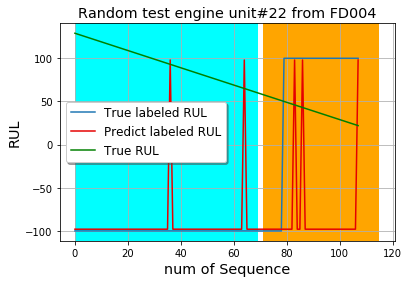

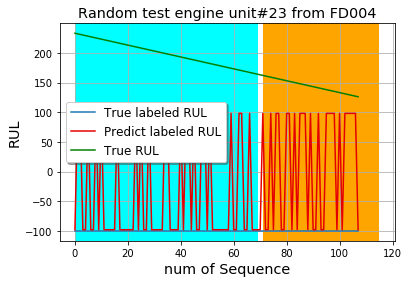

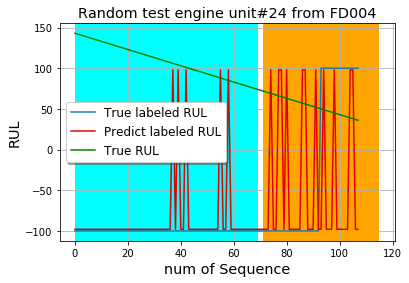

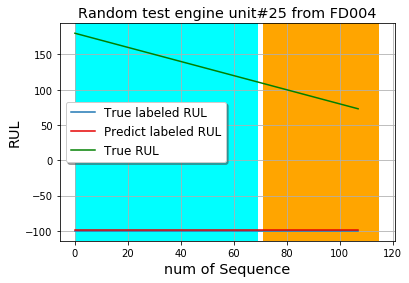

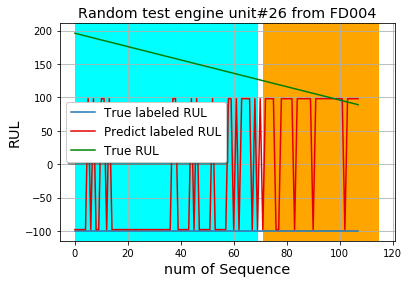

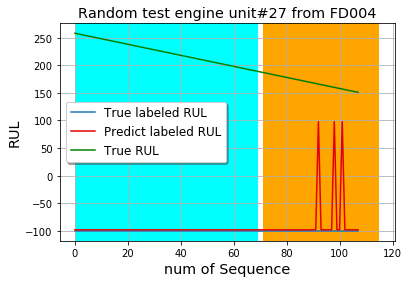

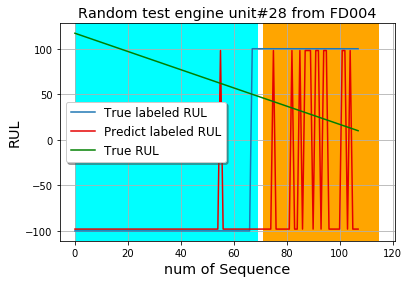

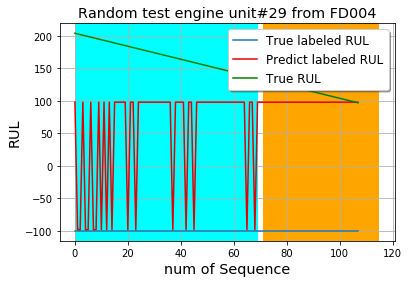

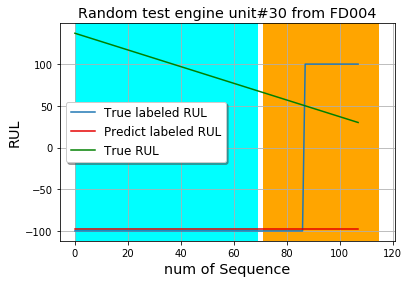

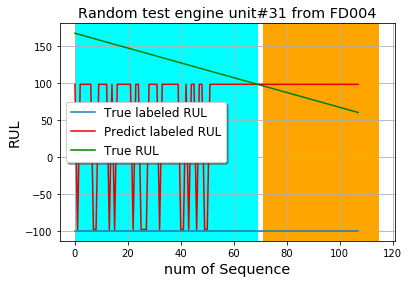

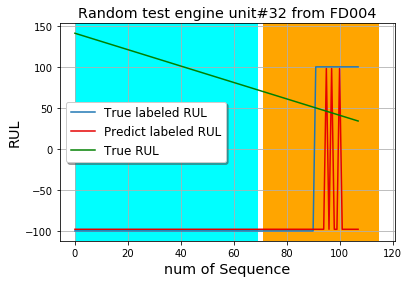

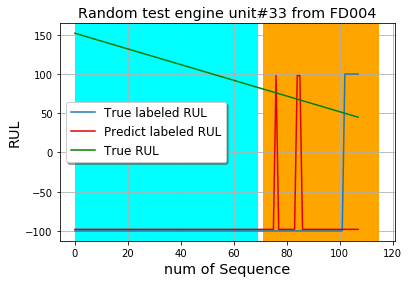

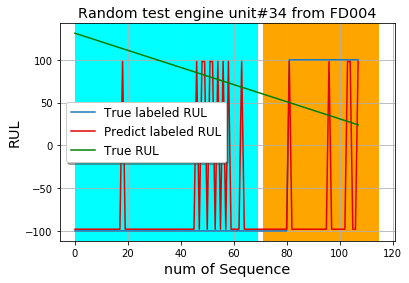

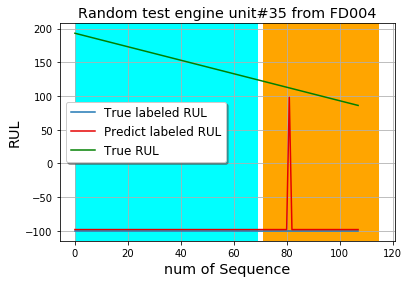

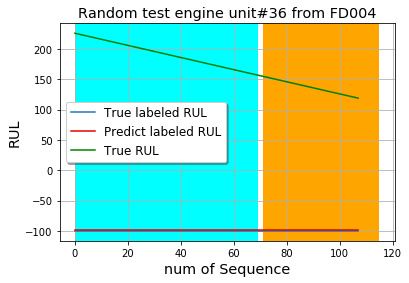

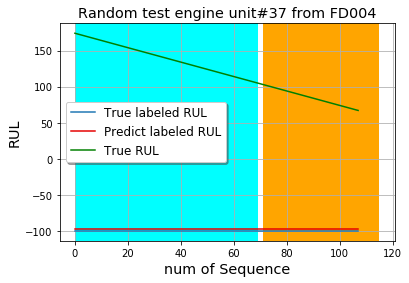

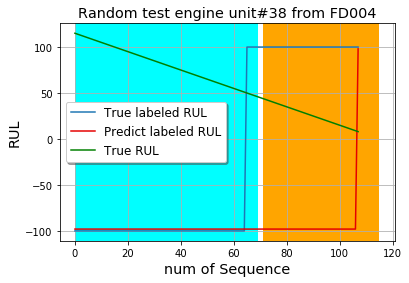

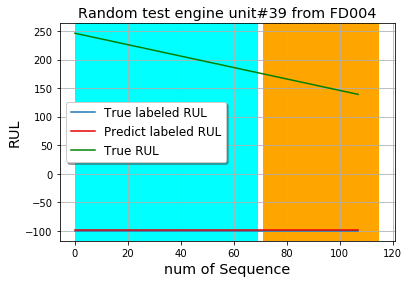

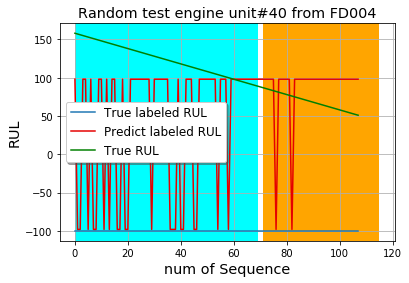

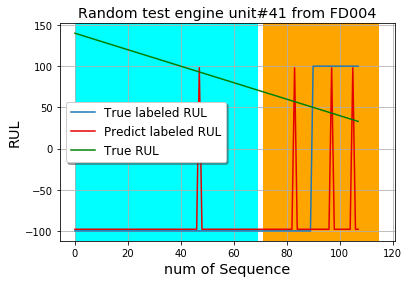

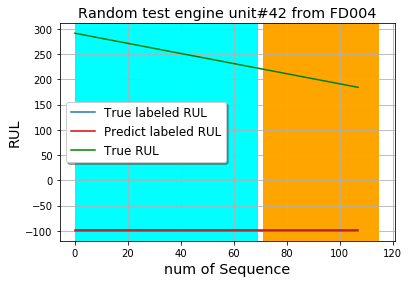

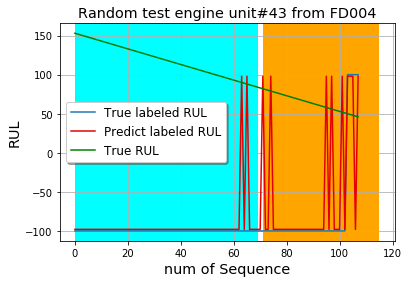

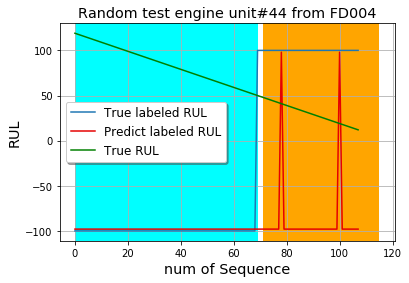

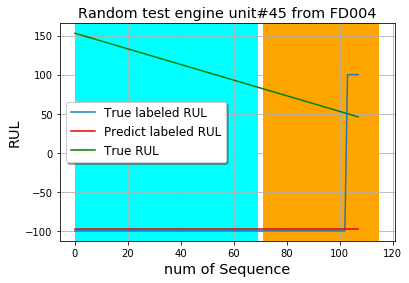

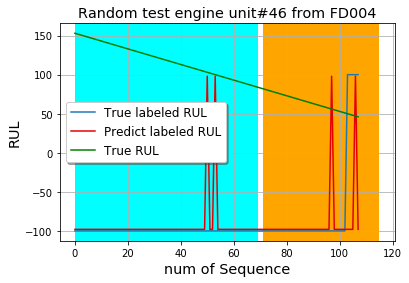

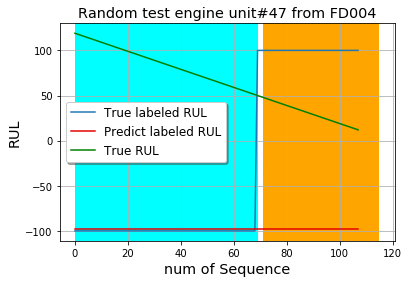

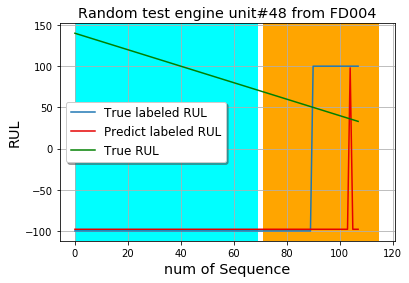

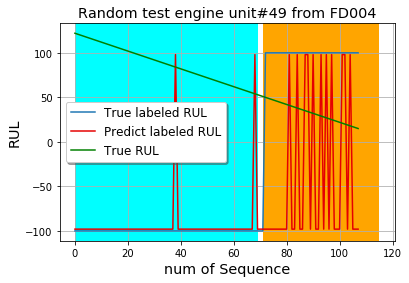

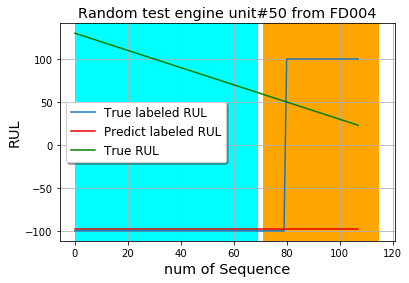

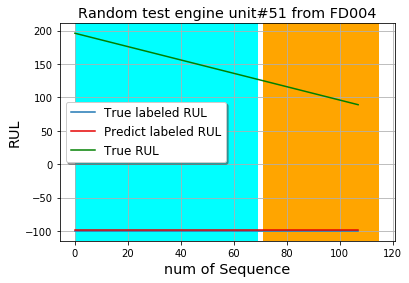

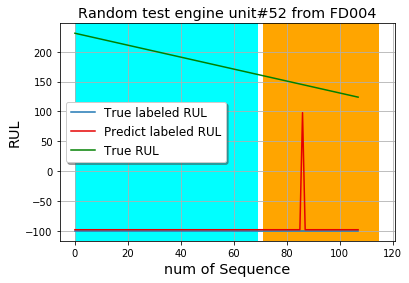

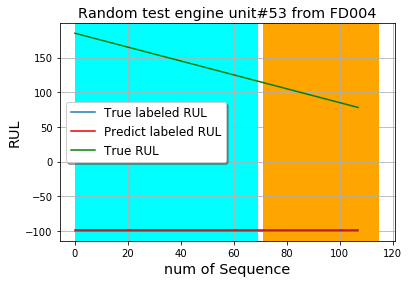

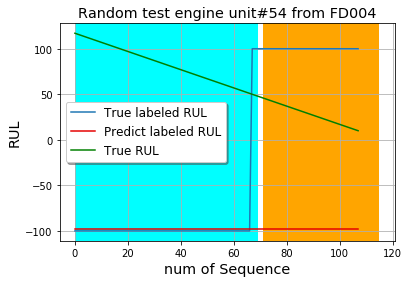

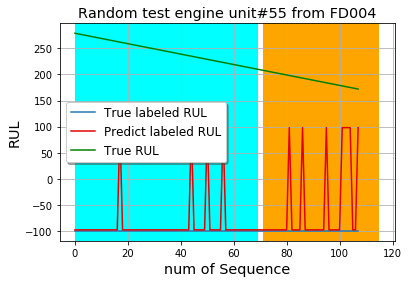

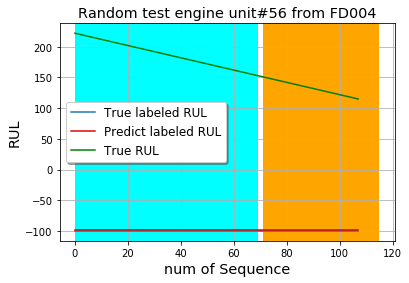

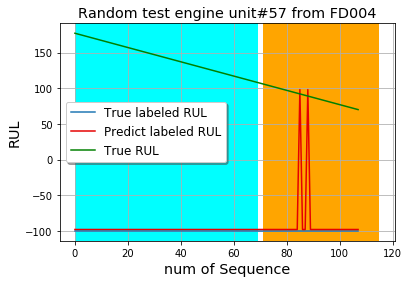

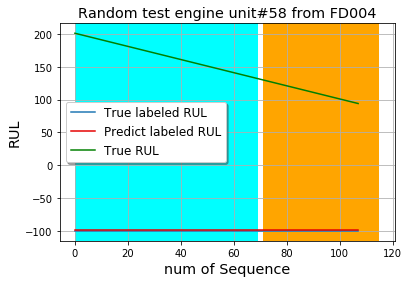

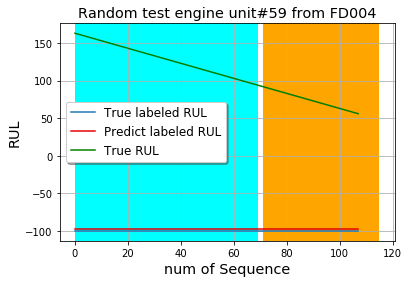

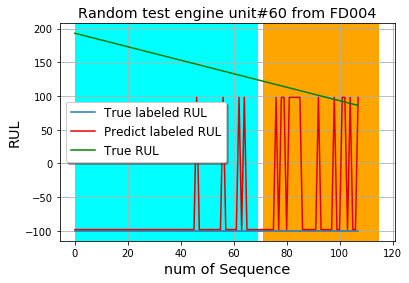

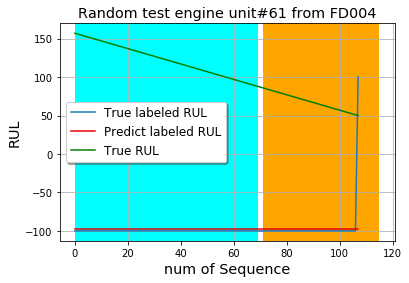

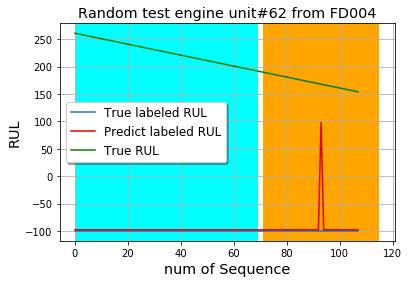

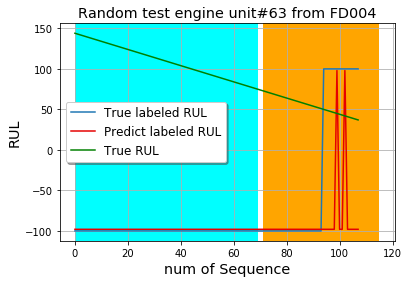

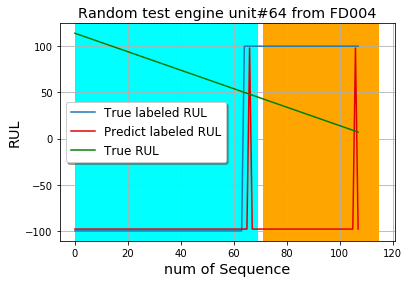

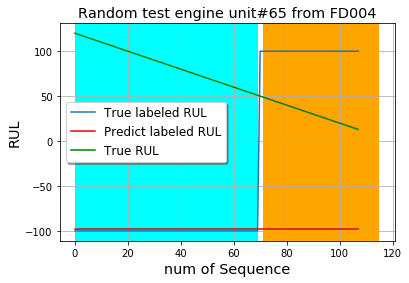

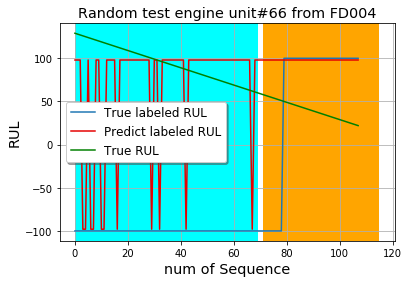

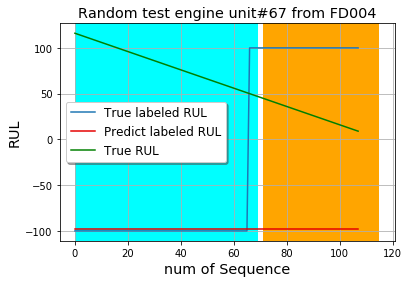

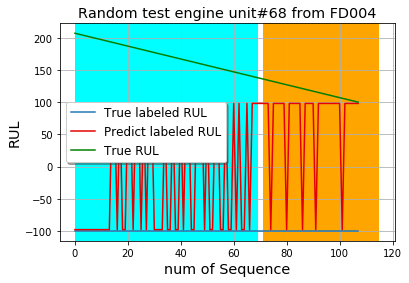

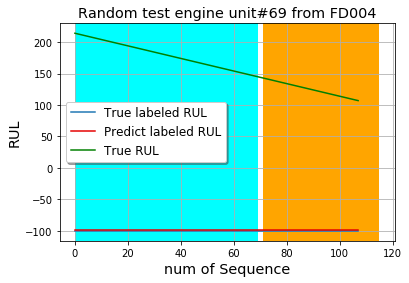

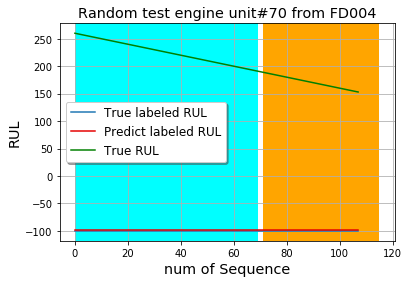

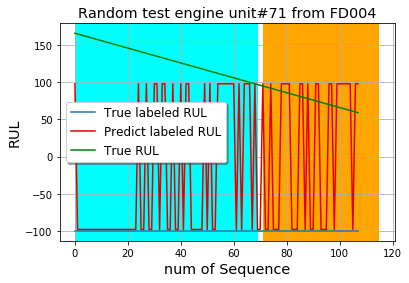

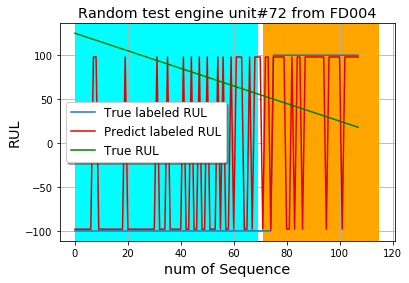

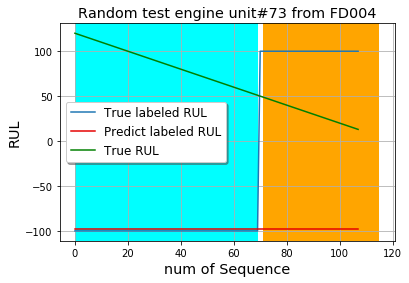

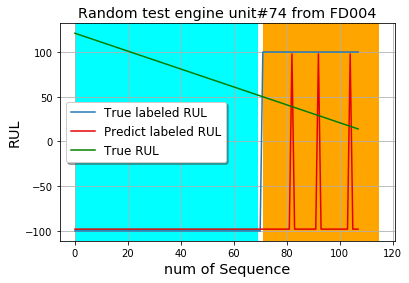

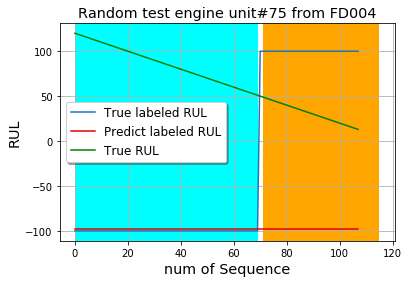

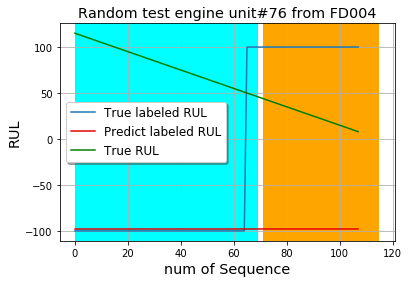

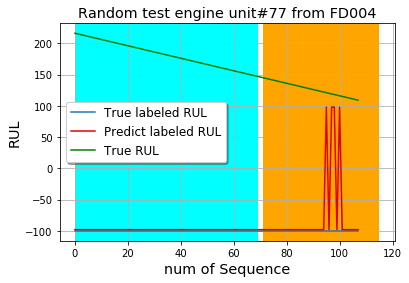

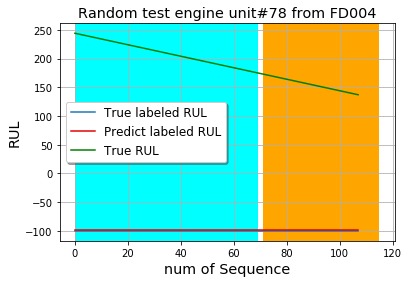

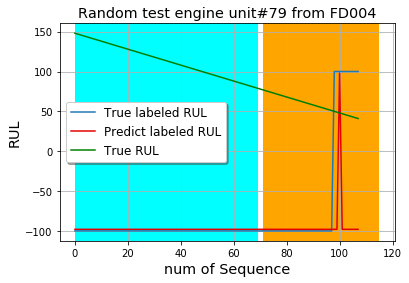

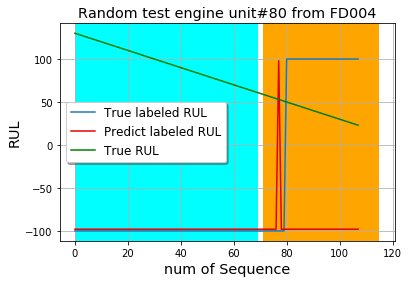

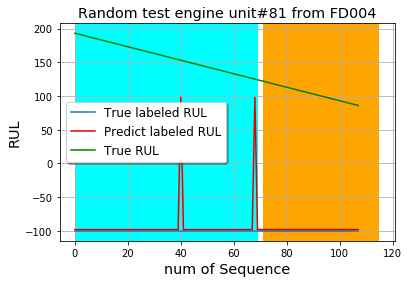

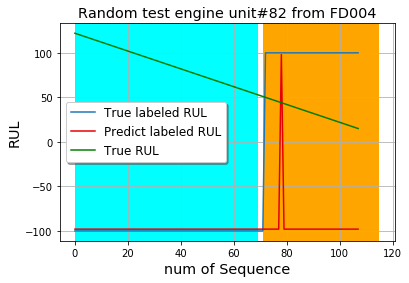

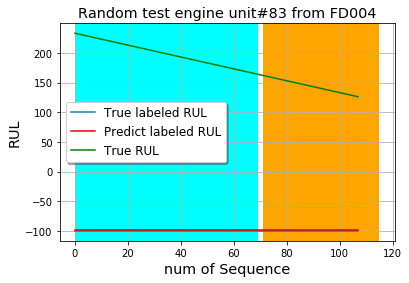

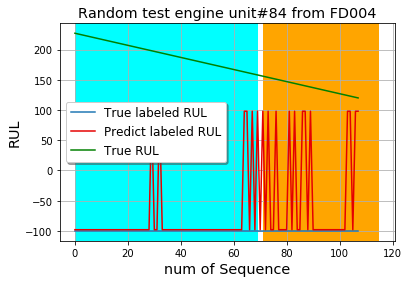

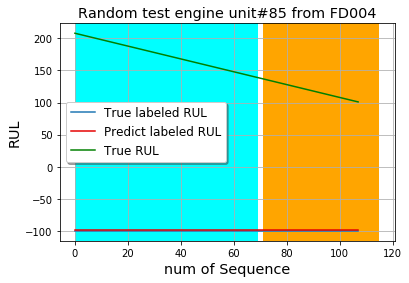

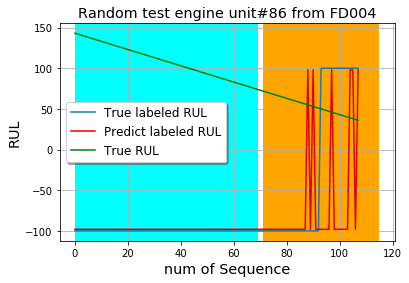

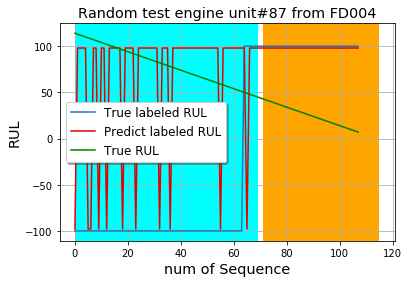

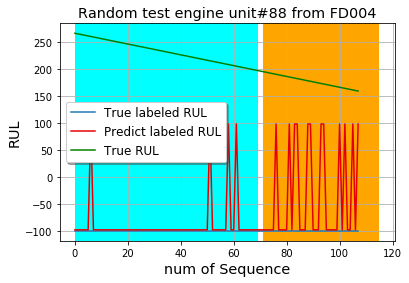

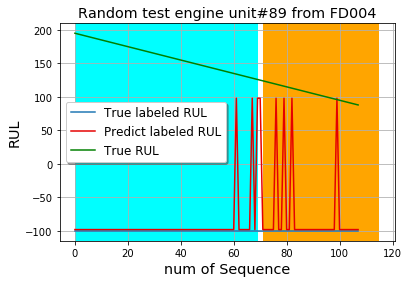

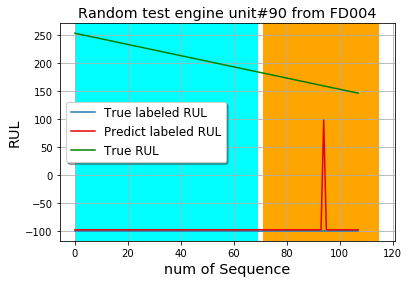

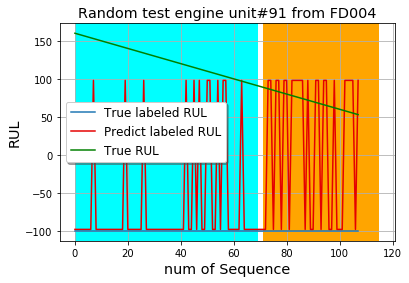

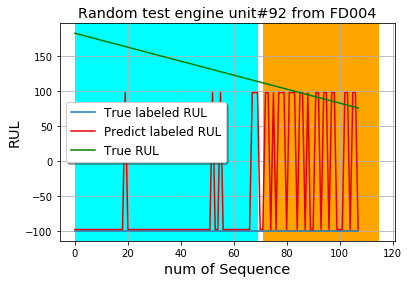

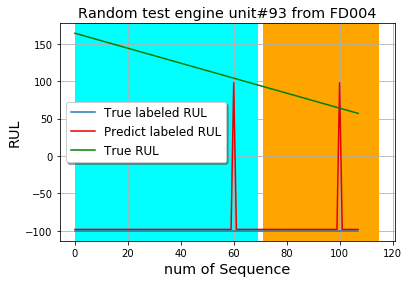

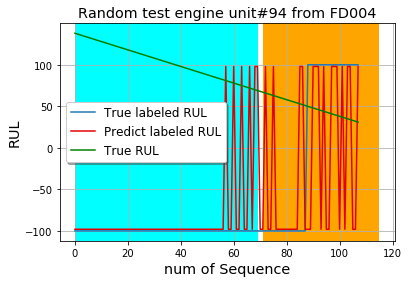

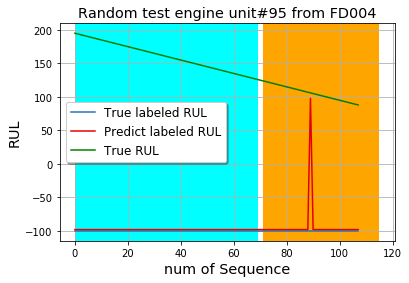

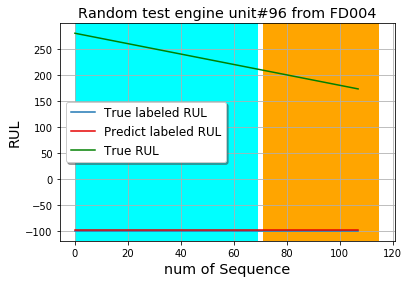

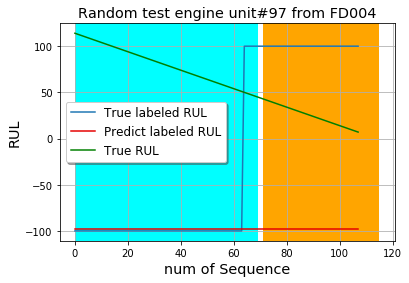

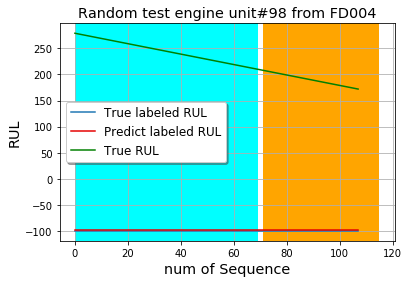

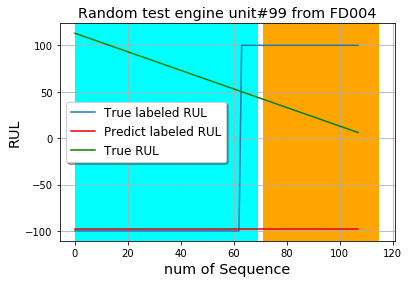

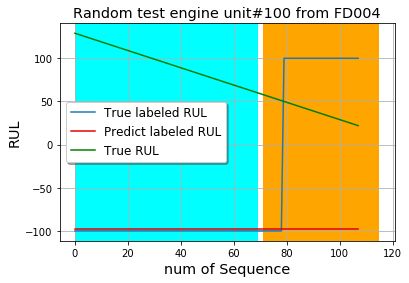

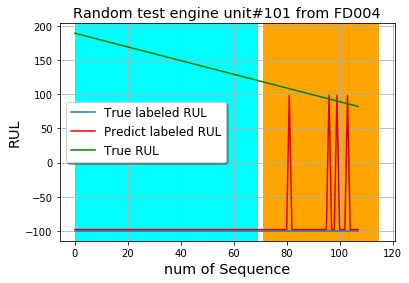

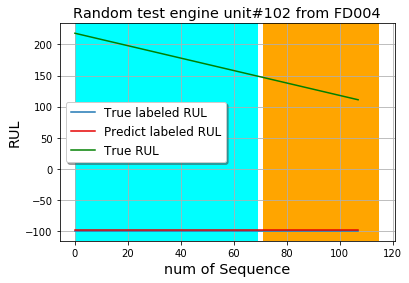

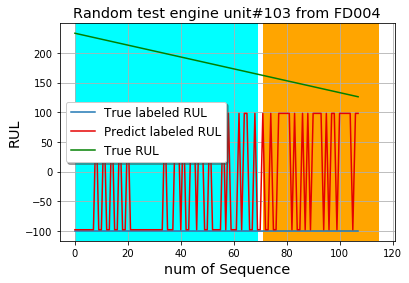

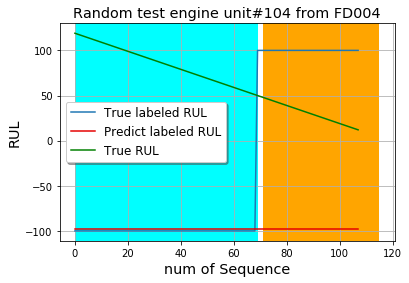

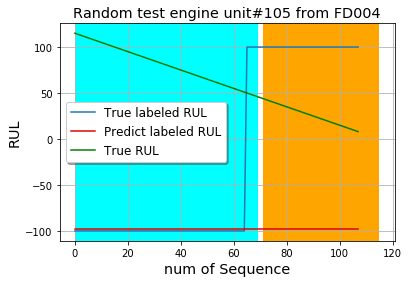

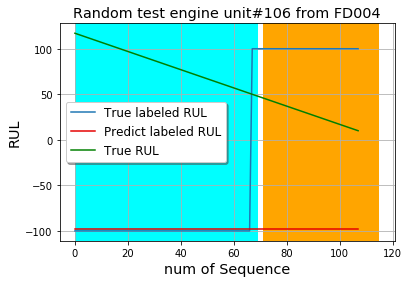

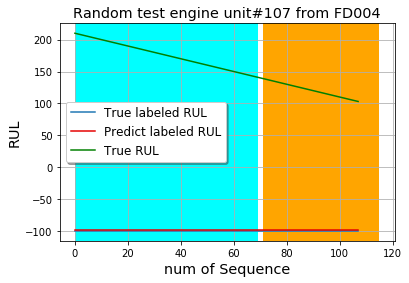

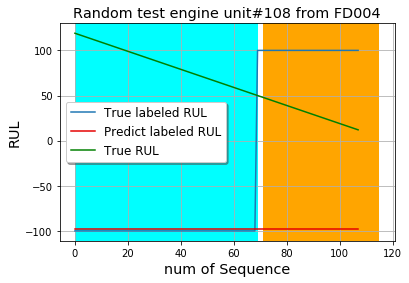

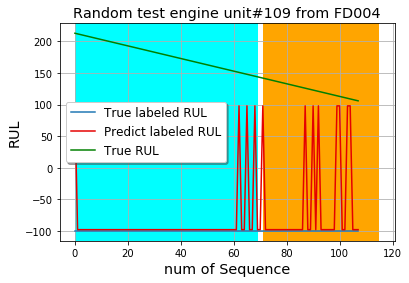

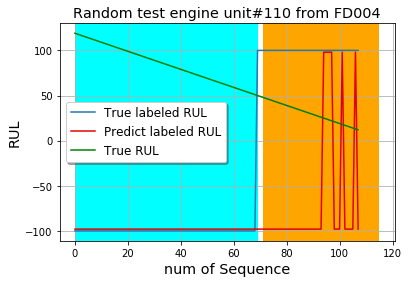

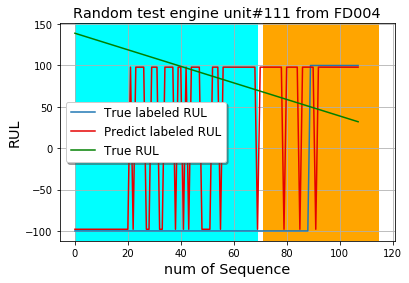

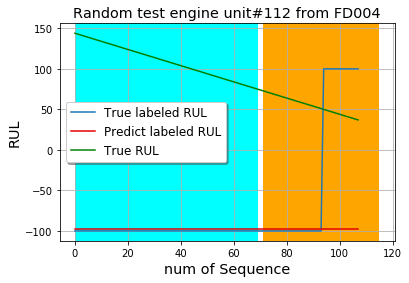

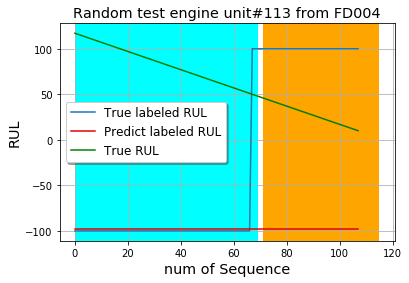

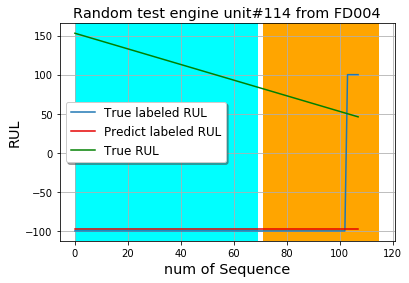

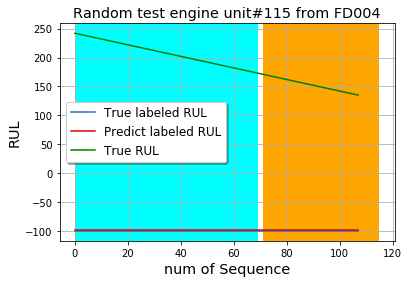

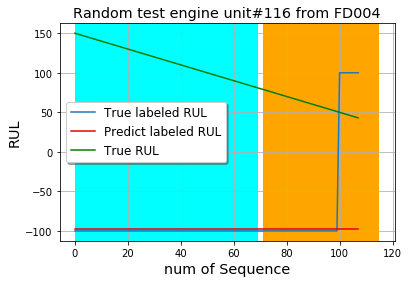

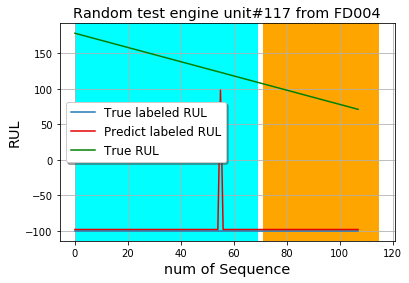

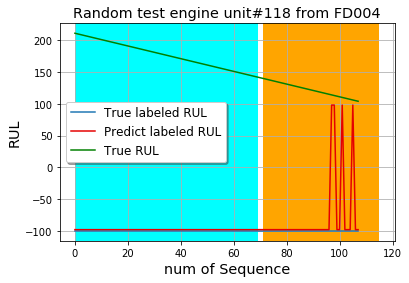

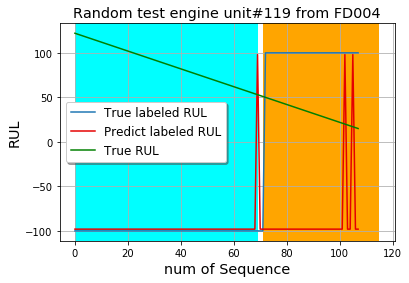

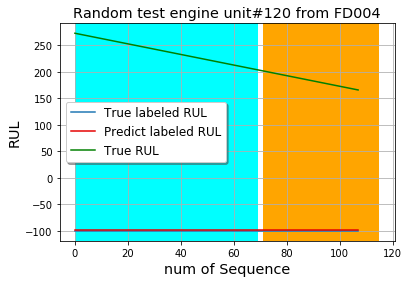

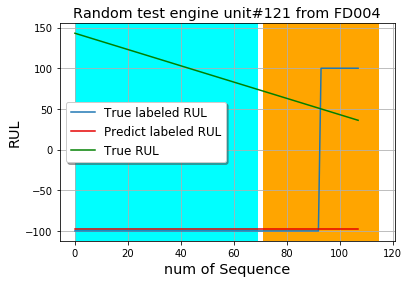

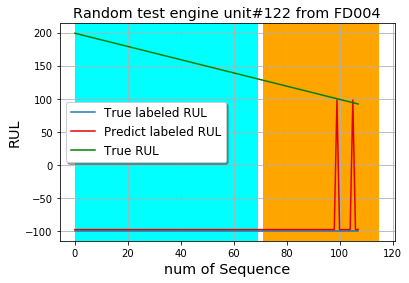

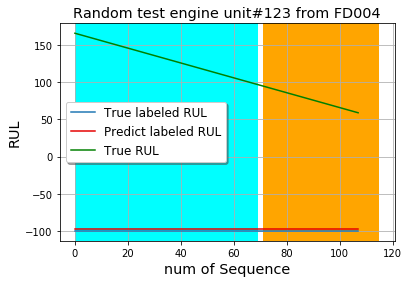

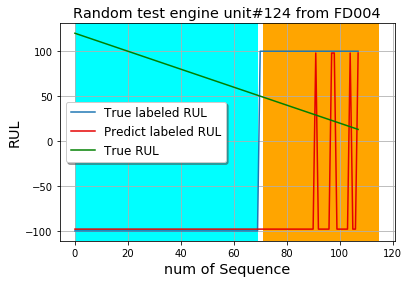

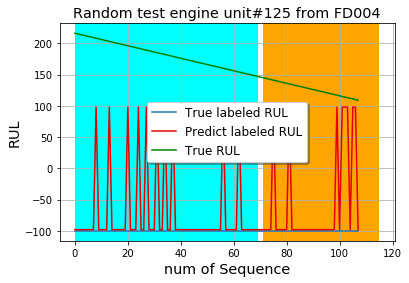

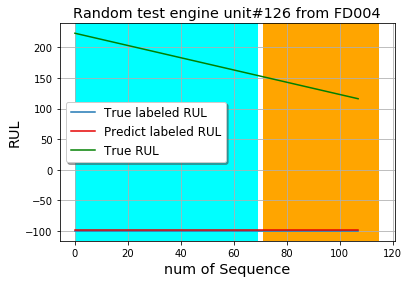

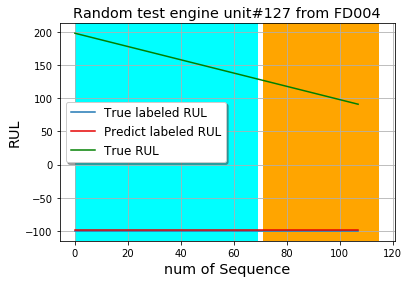

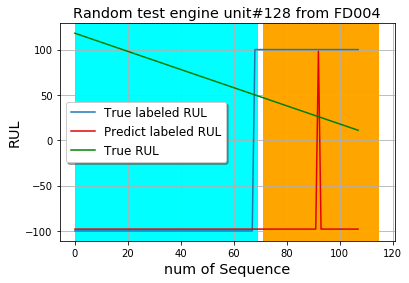

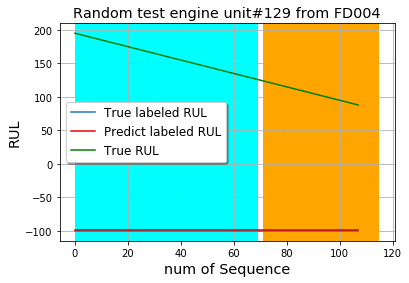

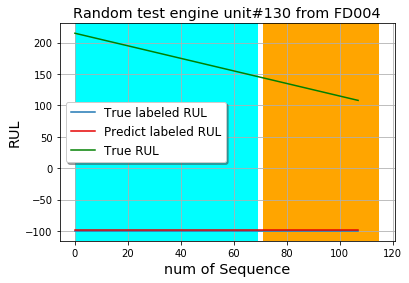

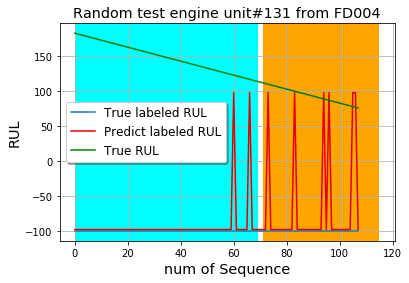

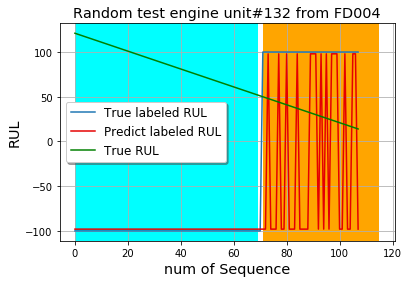

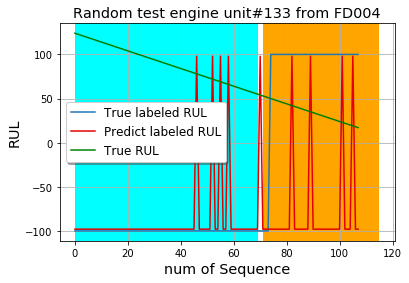

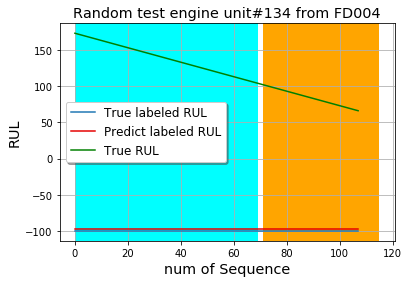

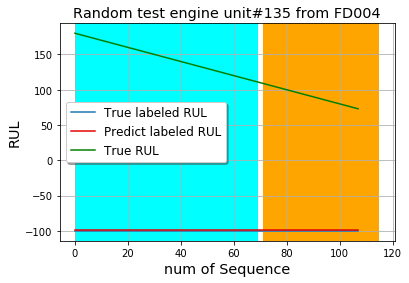

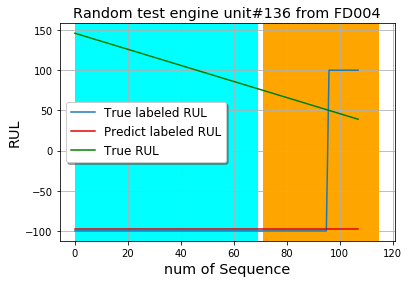

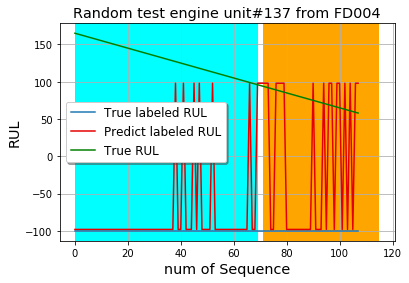

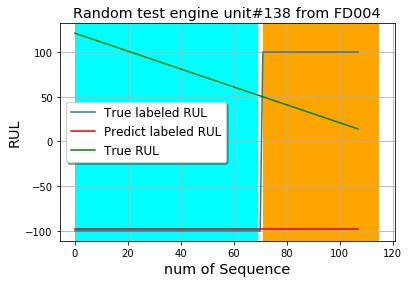

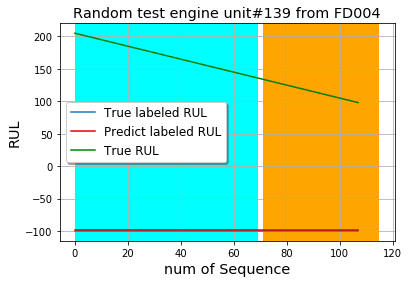

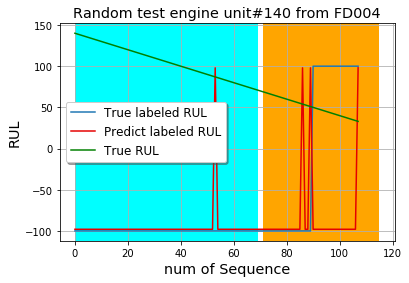

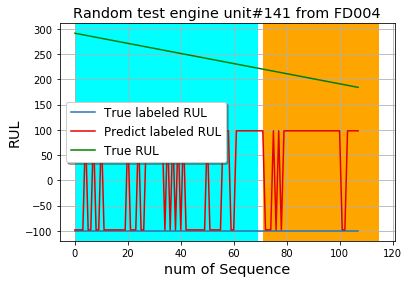

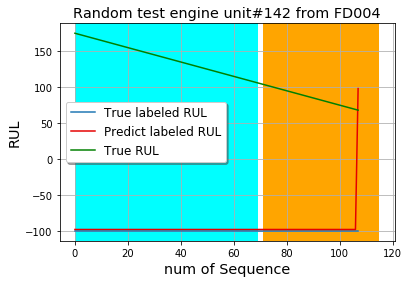

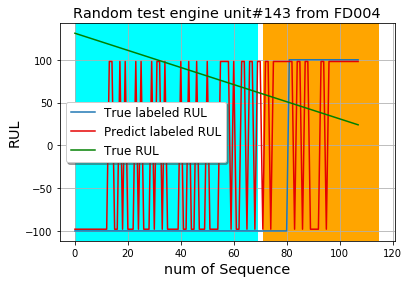

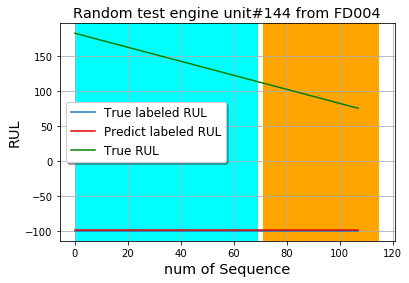

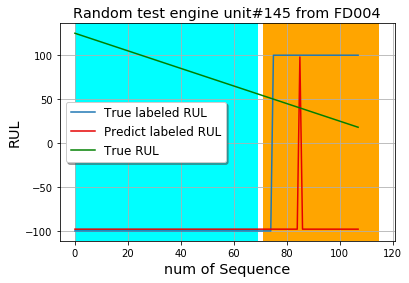

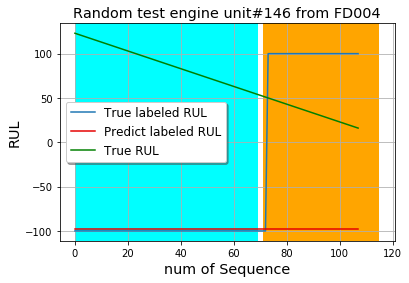

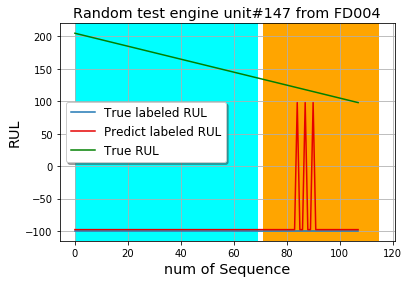

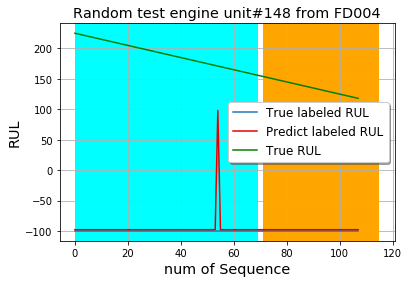

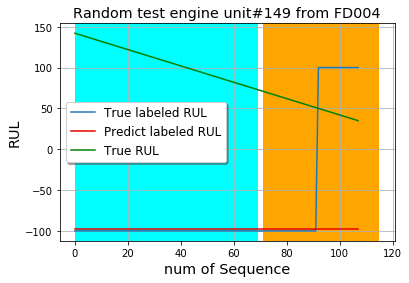

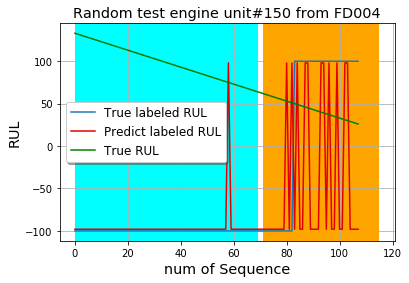

In [12]:
# Plot all the labels estimation with FedSVM for 100 master workers
fig = {}
ax = {}
for i in range(len(X_test_dic)):
    pre = predict(W_Cloud_SGD, X_test_dic[i])
    fig[i], ax[i] = plt.subplots()
    ax[i].plot(Y_test_dic[i] * 100, label='True labeled RUL')
    ax[i].plot(pre * 98, label='Predict labeled RUL', color='#E50000')
    ax[i].plot(Y_test_rul_dic[i], label='True RUL', color='#008000')
    plt.title("Random test engine unit#" + str(i) + " from FD004", fontsize="x-large")
    plt.ylabel("RUL", fontsize="x-large")
    #plt.xlabel("num of Sequence generated by windowing on input dataset", fontsize="x-large")
    plt.xlabel("num of Sequence", fontsize="x-large")
    ax[i].legend(shadow=True, fontsize='large')
    ax[i].grid()
    ax[i].axvspan(71, 115, facecolor='#FFA500')
    ax[i].axvspan(0, 69, facecolor='#00FFFF')

dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/fog&cloud/FD004/Results/Lable prediction/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
#for i in range(len(X_test_dic)):
#    fig[i].savefig("FD004 asynchronous Label prediction with FedSVM for machine number_" + str(i) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
#    fig[i].savefig("FD004 asynchronous Label prediction with FedSVM for machine number_" + str(i) + ".png", format='png', dpi=1200, bbox_inches='tight')


In [13]:
# Save Specific figures
dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/fog&cloud/FD004/Results/Lable prediction/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
fig[132].savefig("FD004 asynchronous Label prediction with FedSVM for machine number_" + str(132) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
fig[132].savefig("FD004 asynchronous Label prediction with FedSVM for machine number_" + str(132) + ".png", format='png', dpi=1200, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
